/afs/crc.nd.edu/user/m/mcarlozo/.conda/envs/Toy_Problem_env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Date and Time:  04-May-2023 (15:12:04)
400
Runs: 2
BO Iterations: 10
%%%%%%%%%%%%%%%%%%%%%%%%%%
-------------------
Emulator?: False
______________________________
Sparse Grid?: False
Objective Function: LN_obj
-  -  -  -  -  -  -  -  -  -  -
Separation Factor Train/Test: 1
Lengthscale Set To: 1
Explore Bias Multiplier: 1.0
Run Number:  1
Run Number:  2


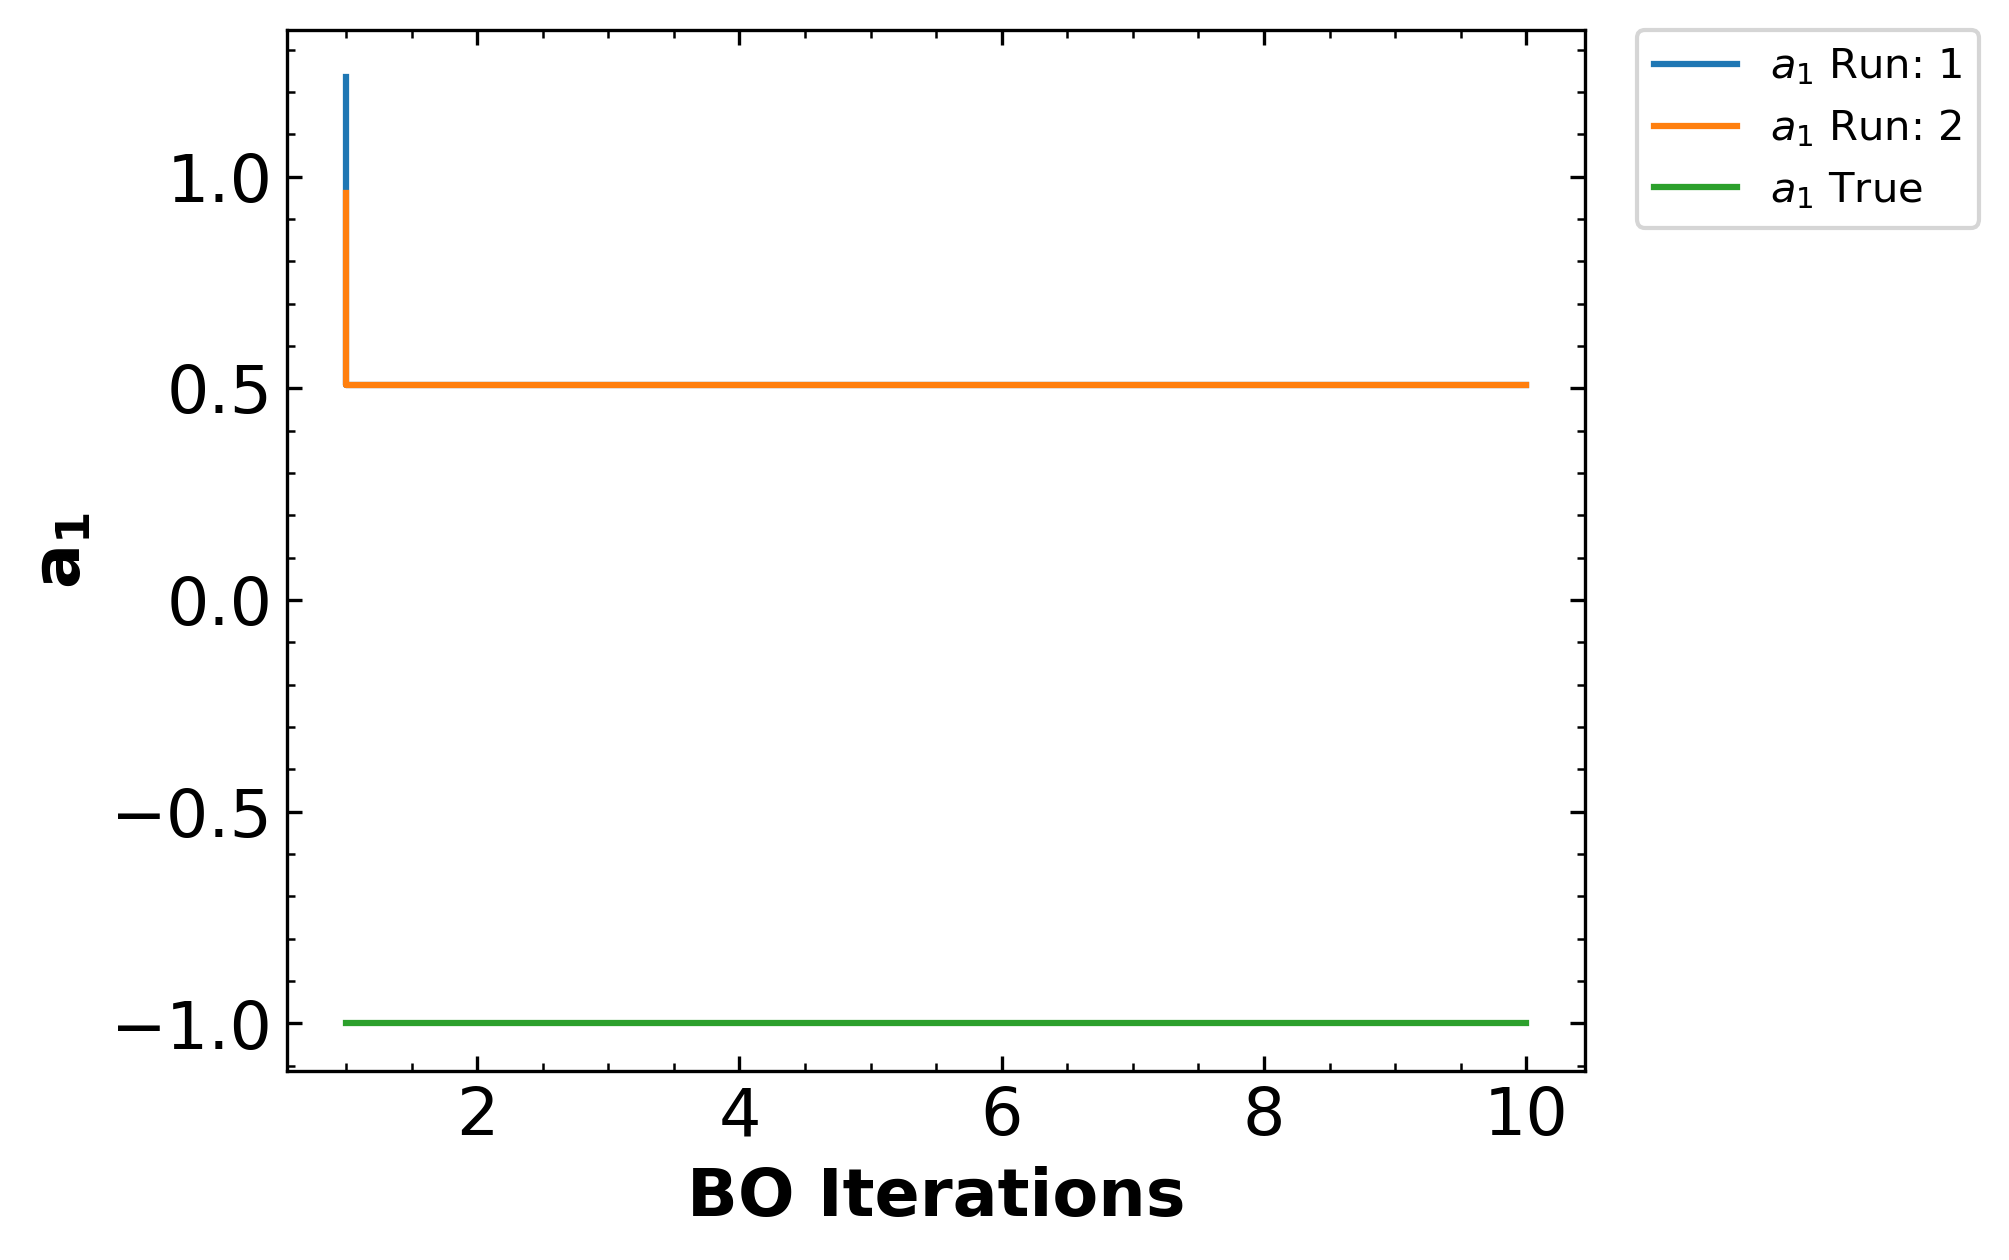

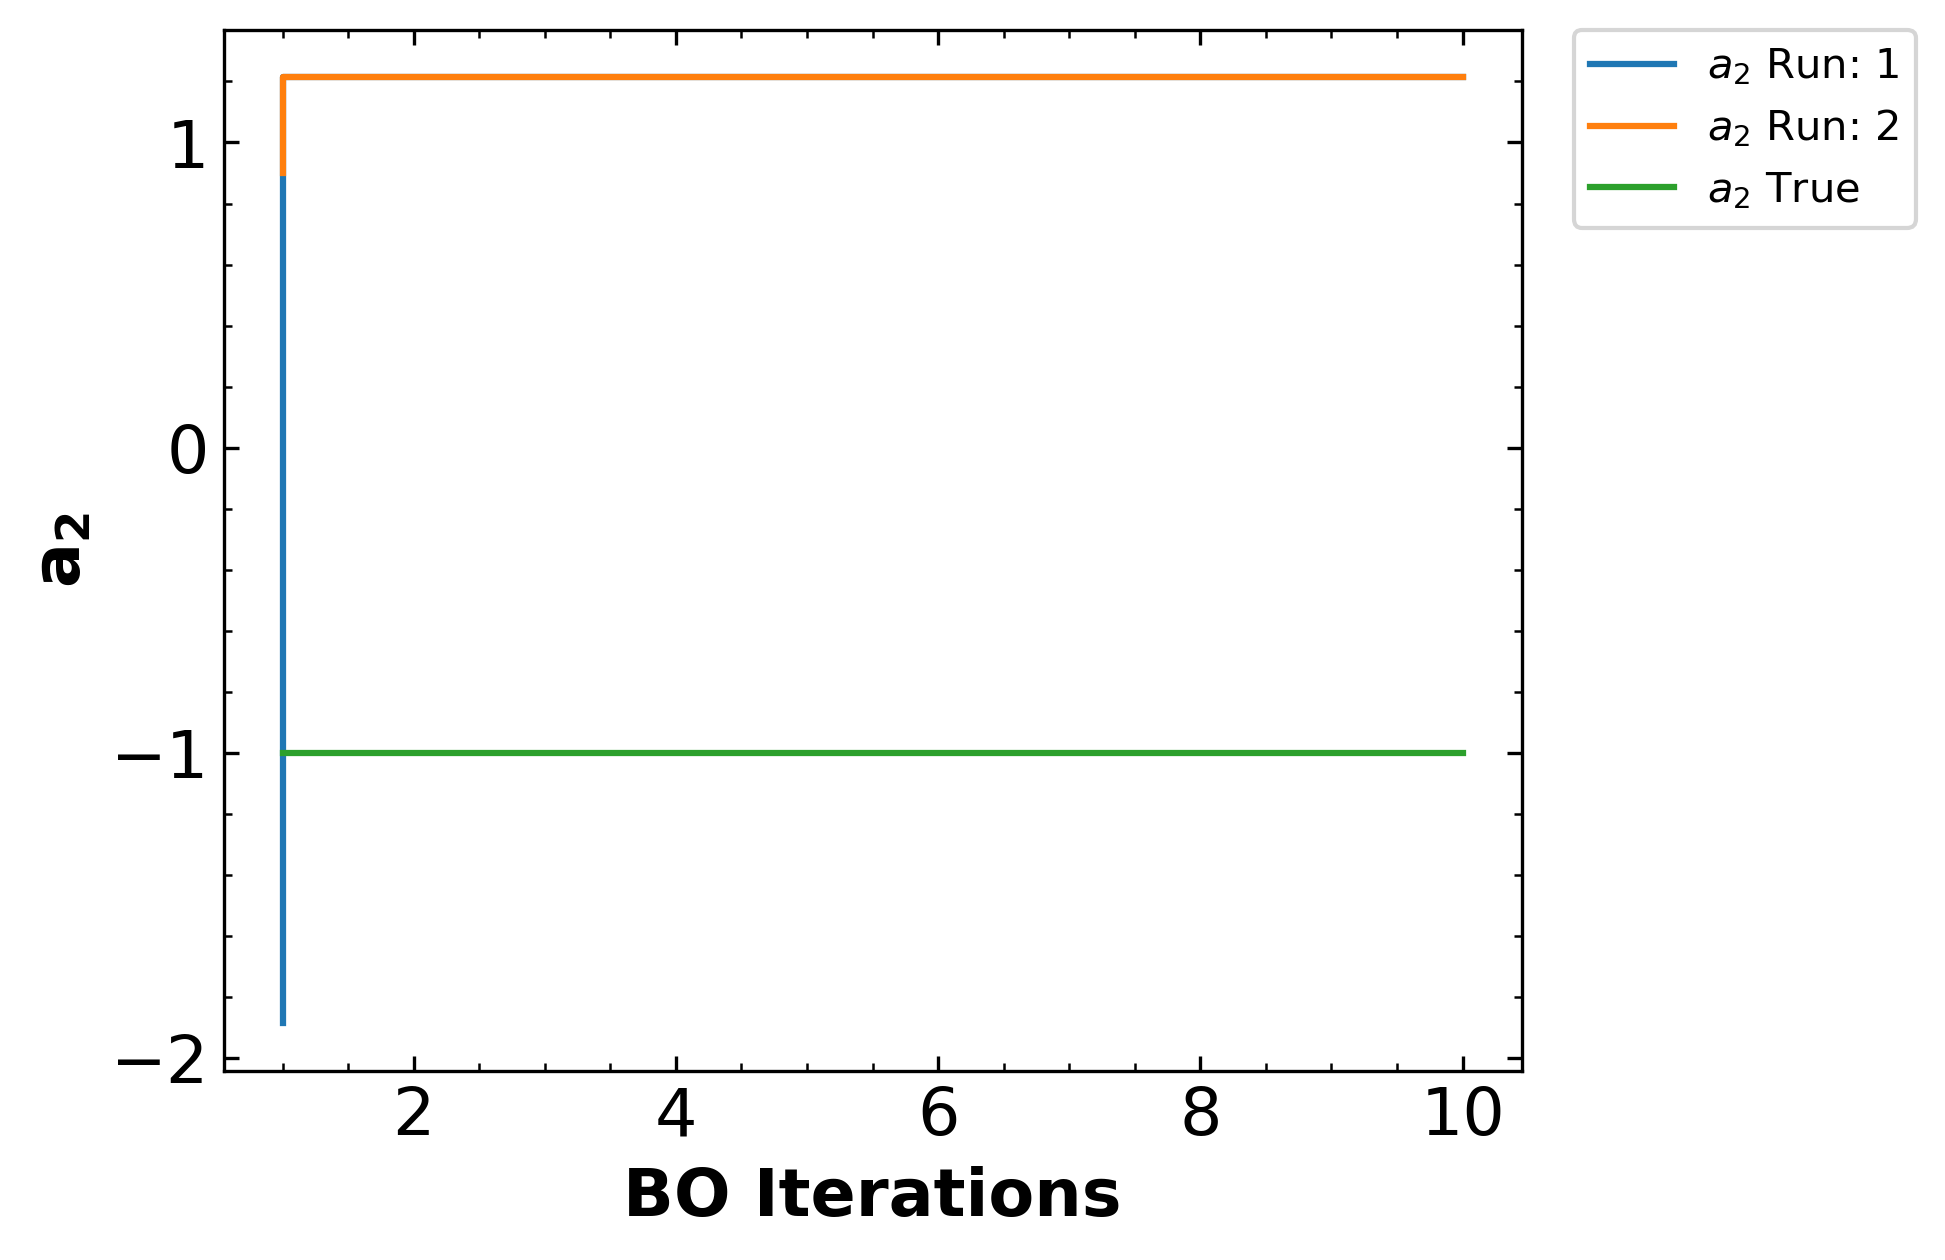

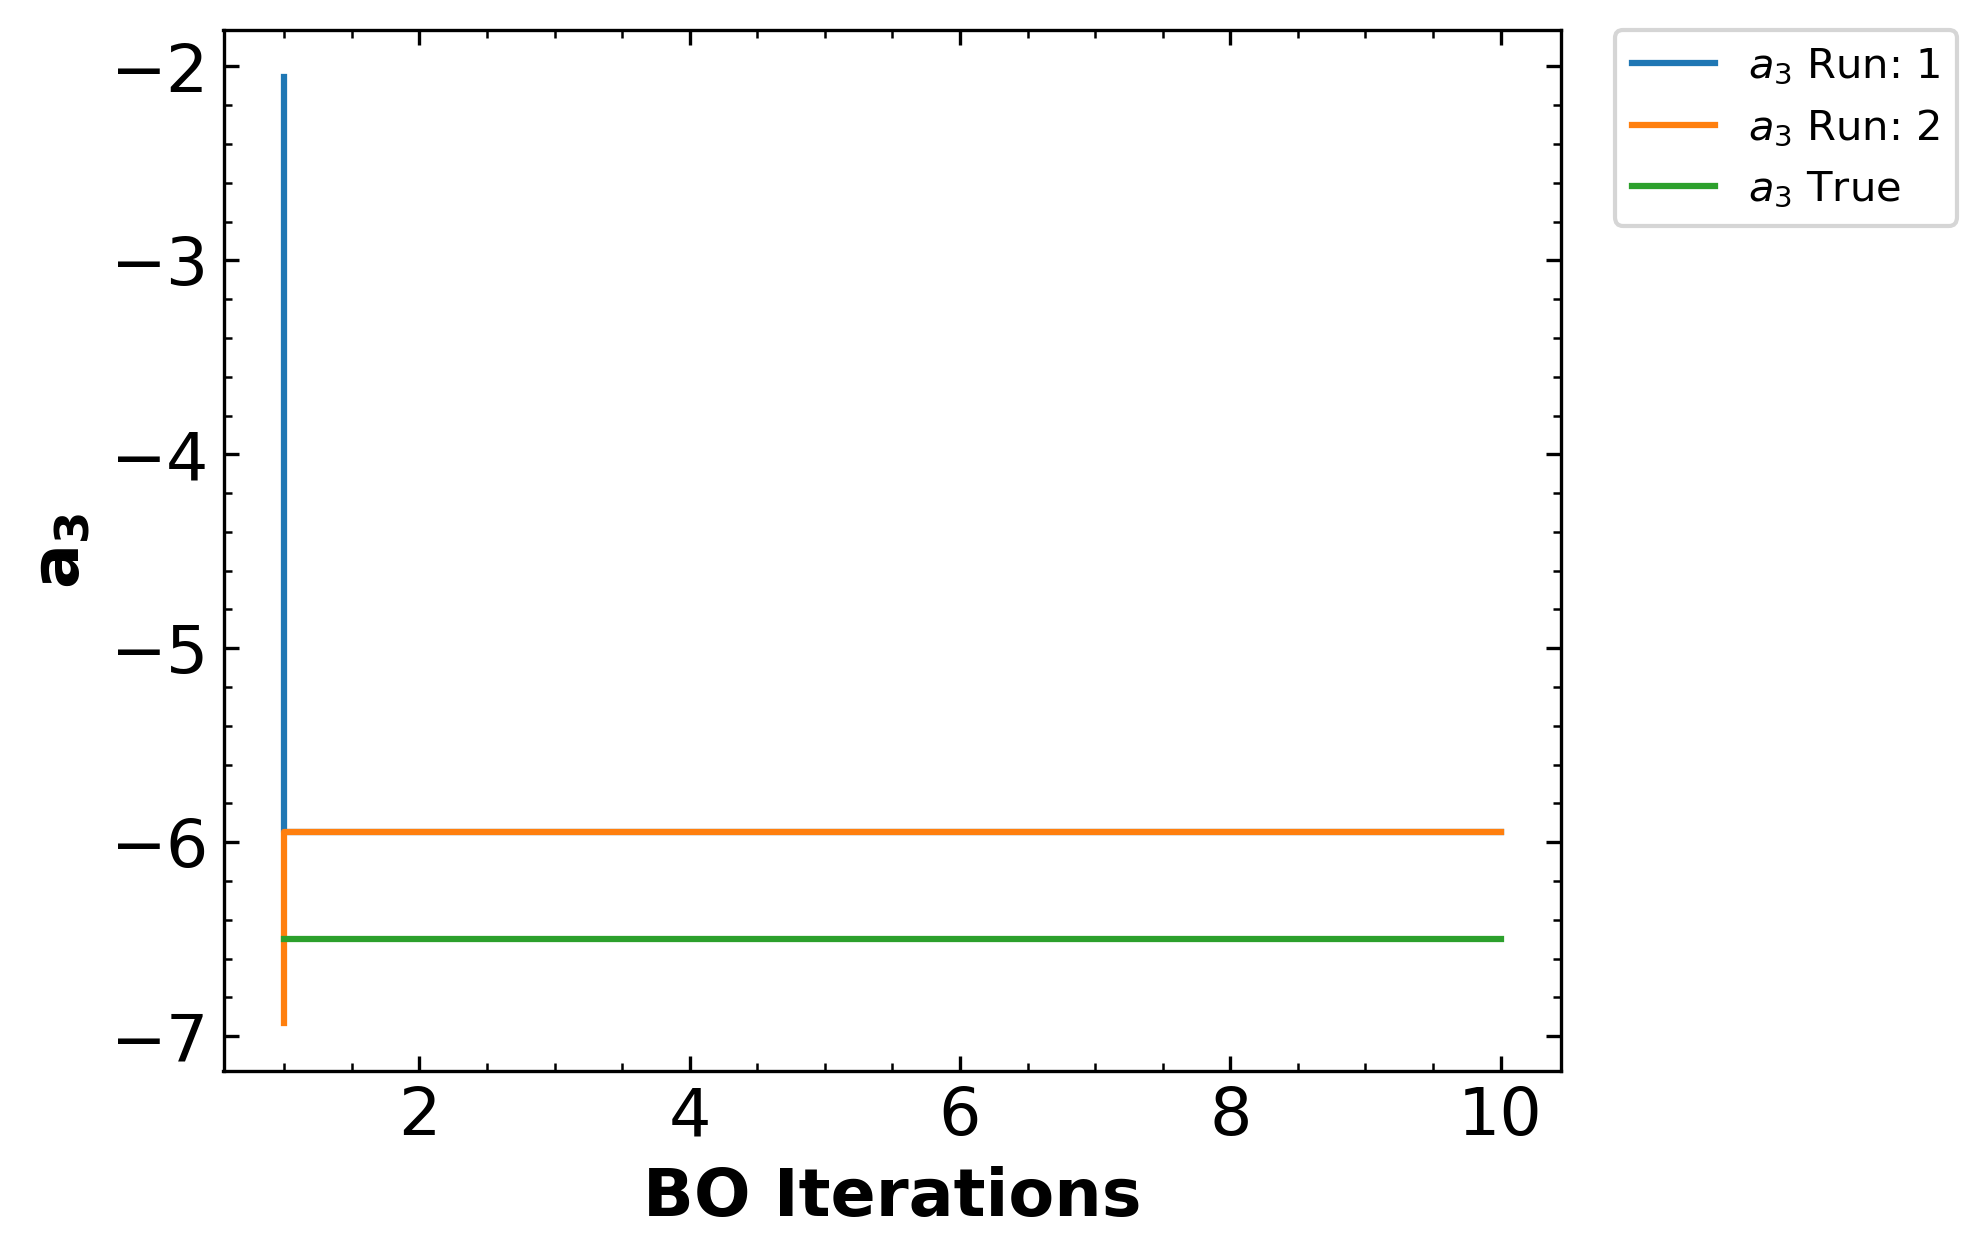

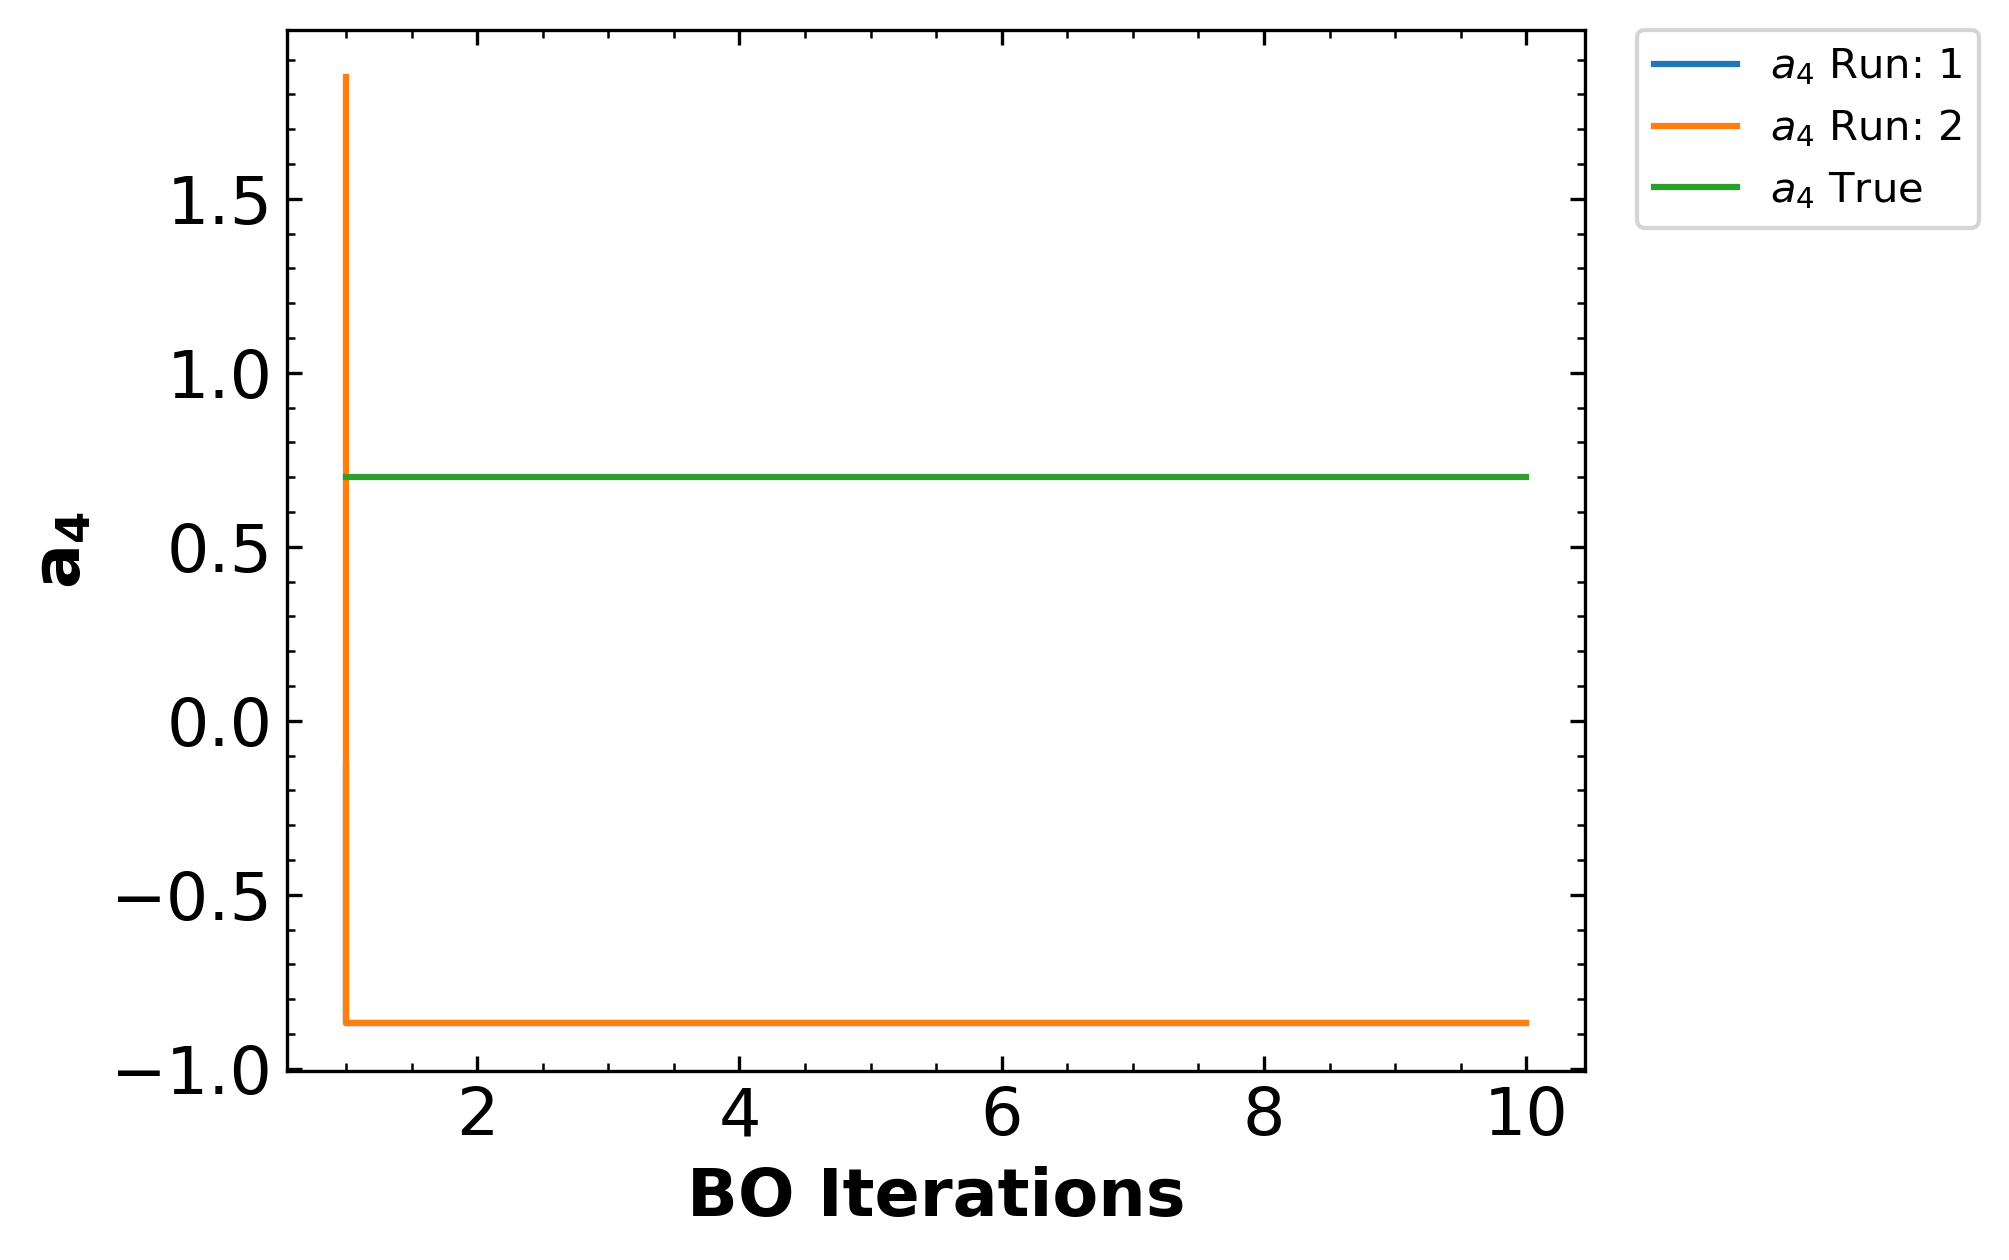

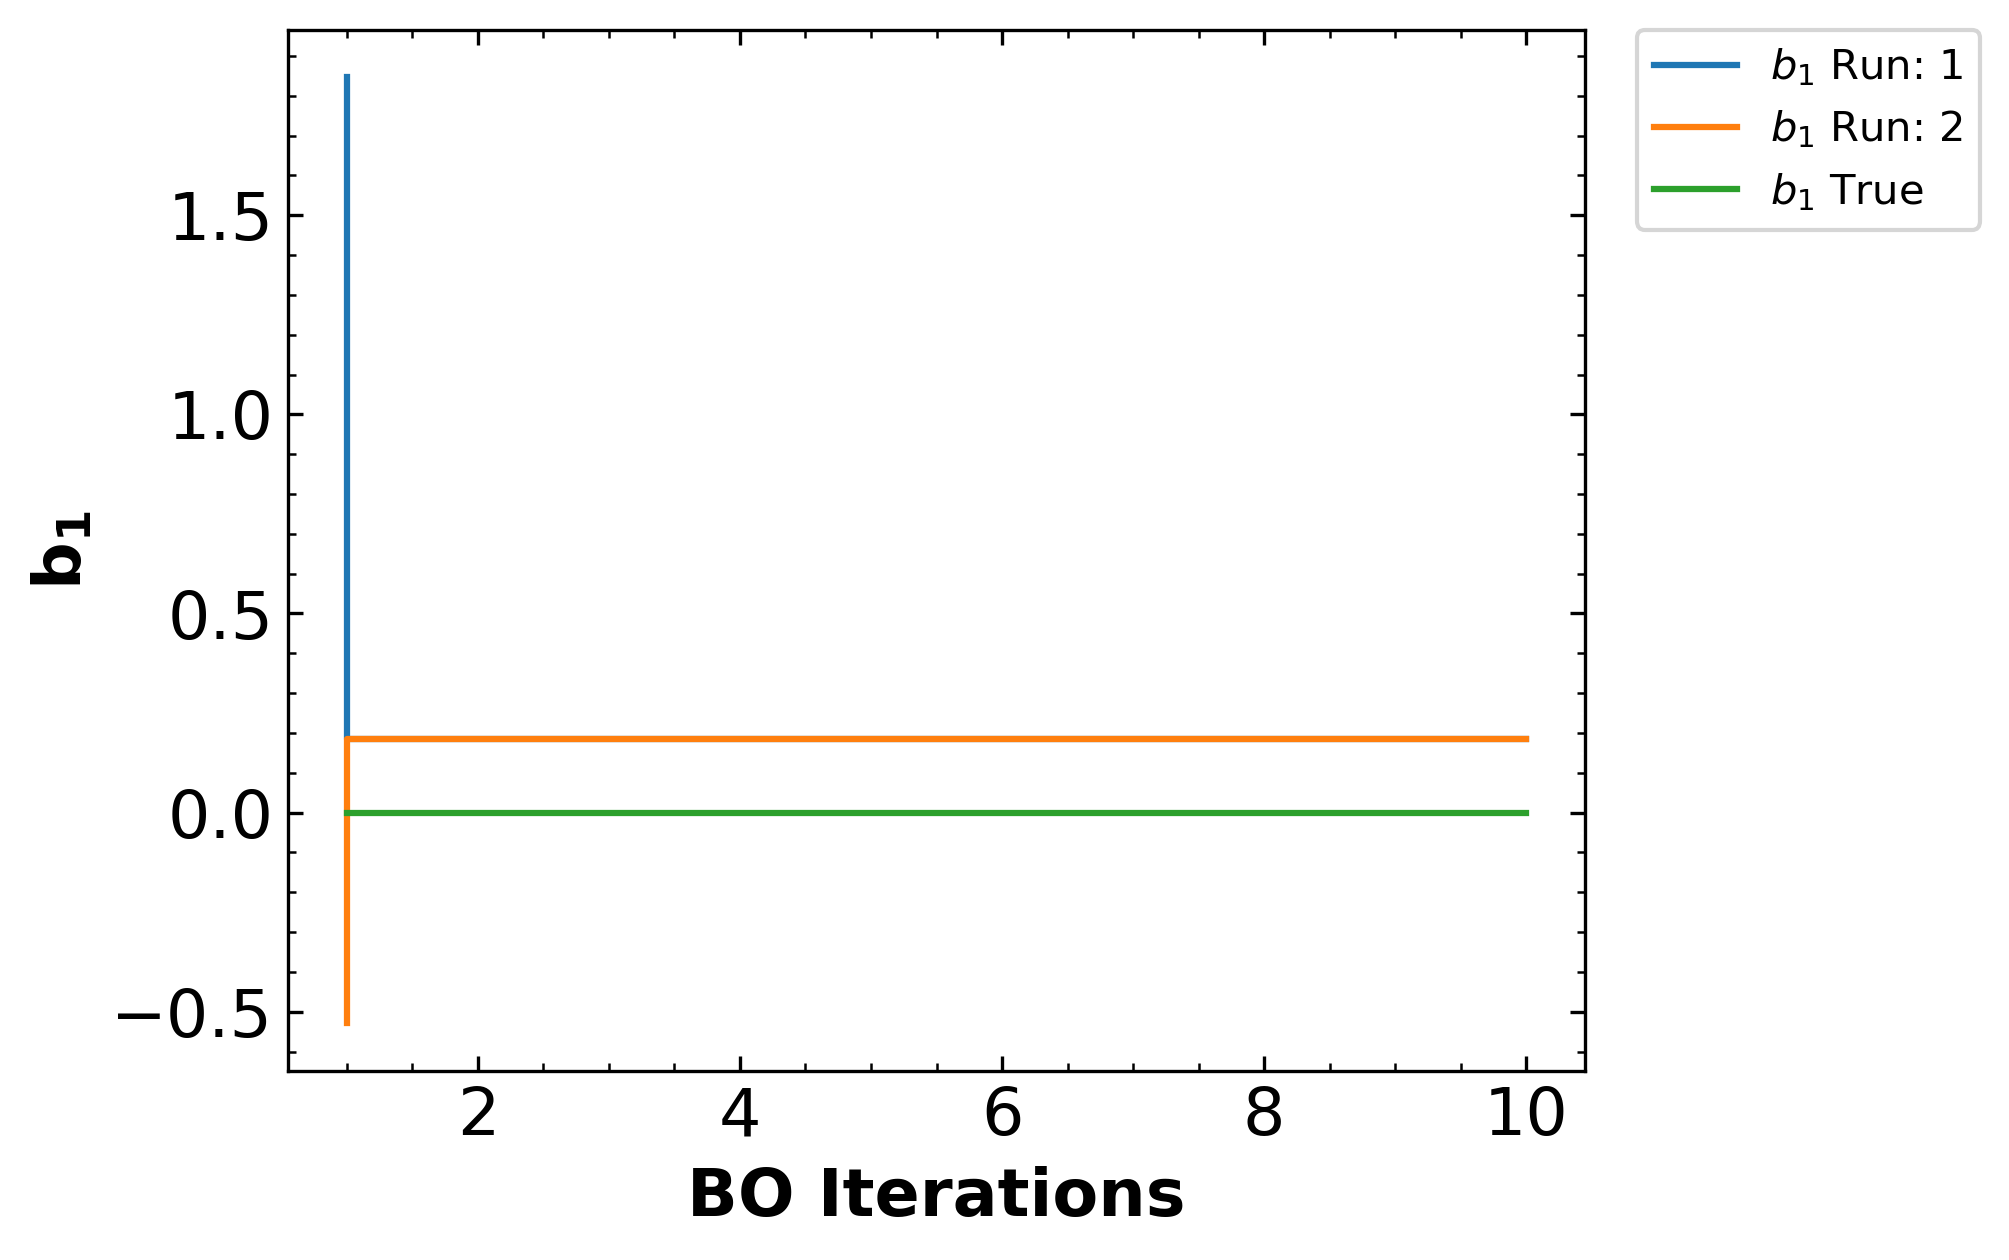

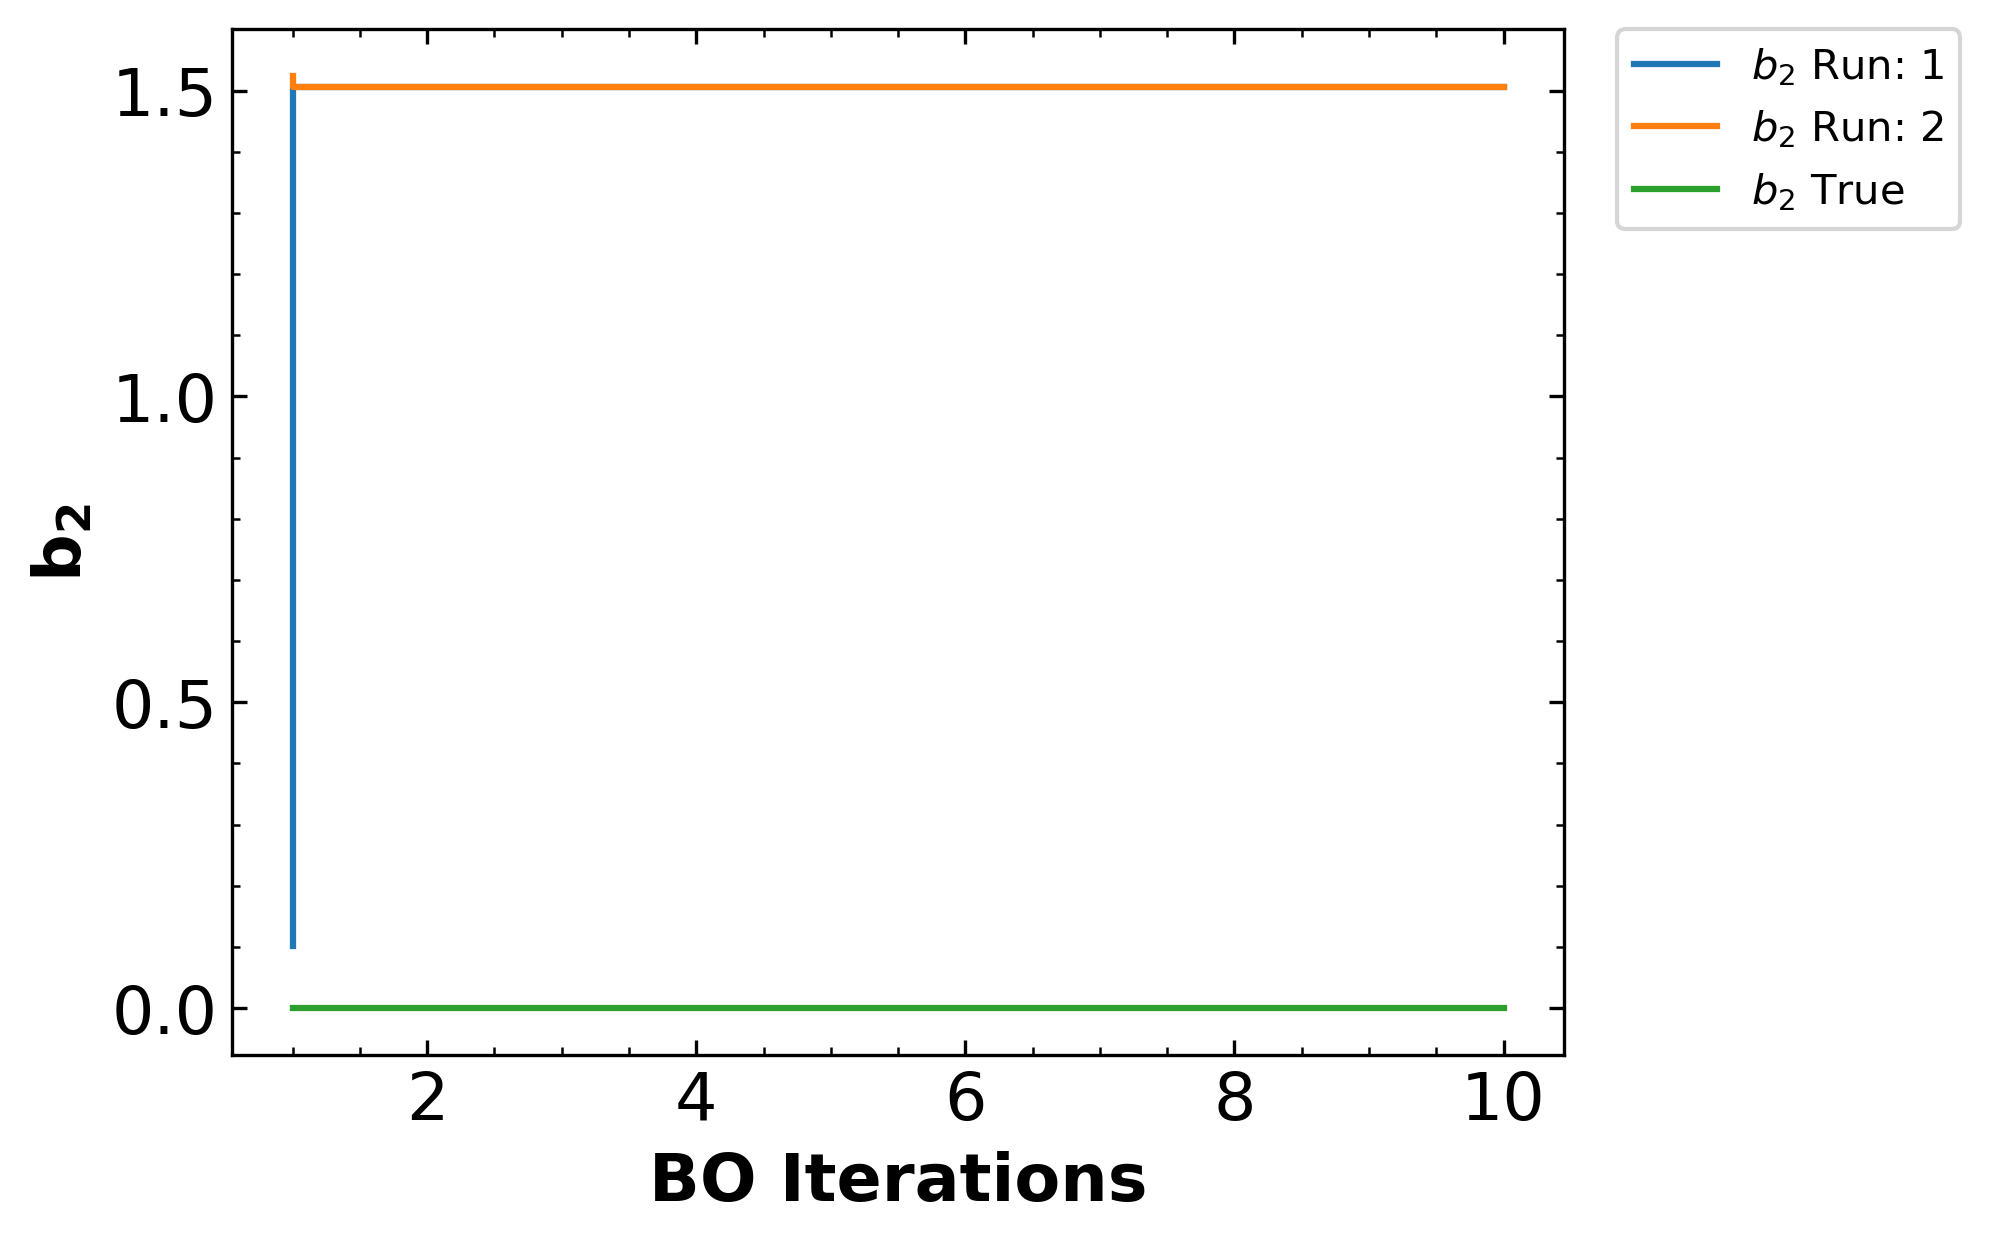

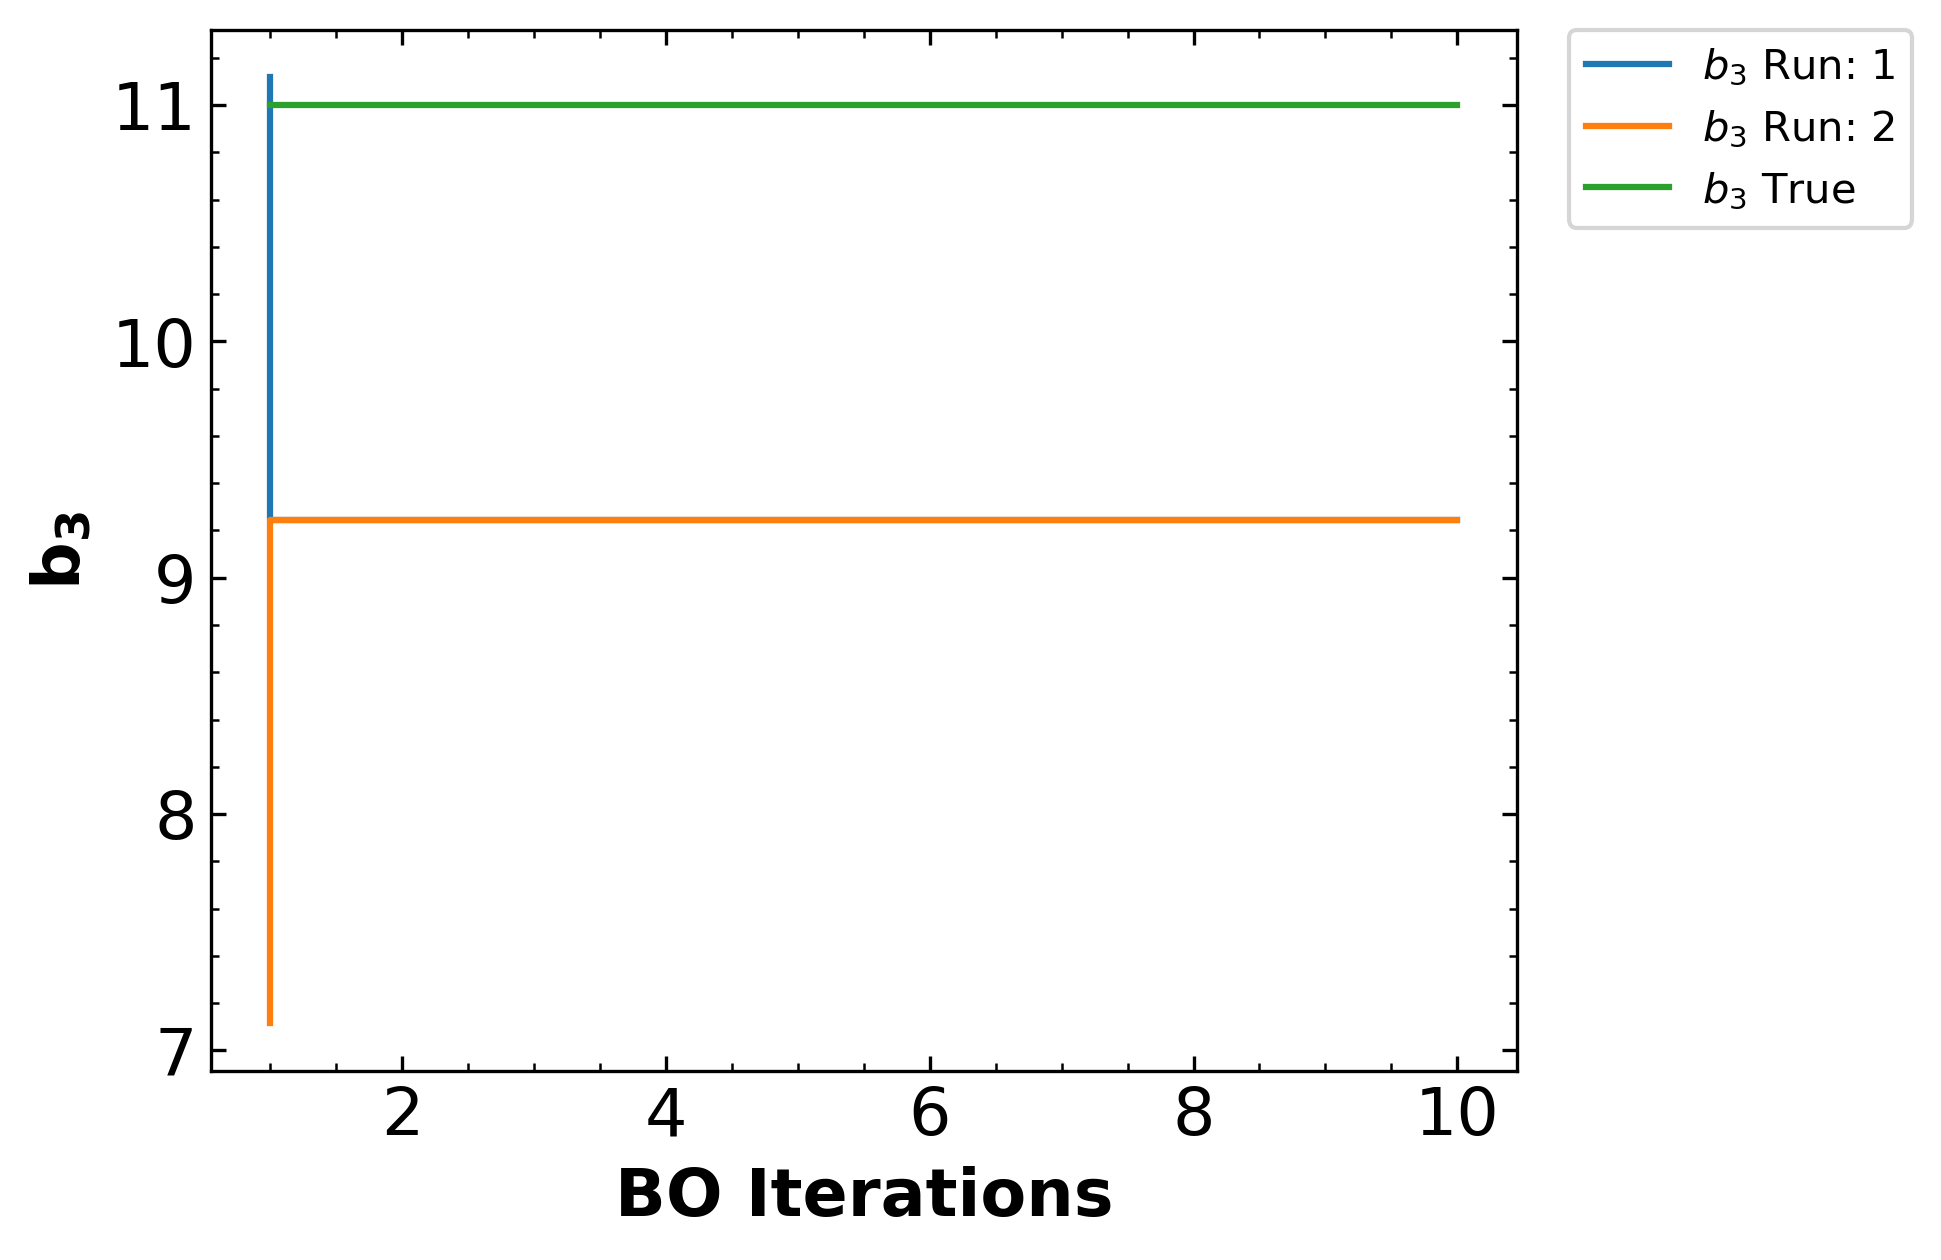

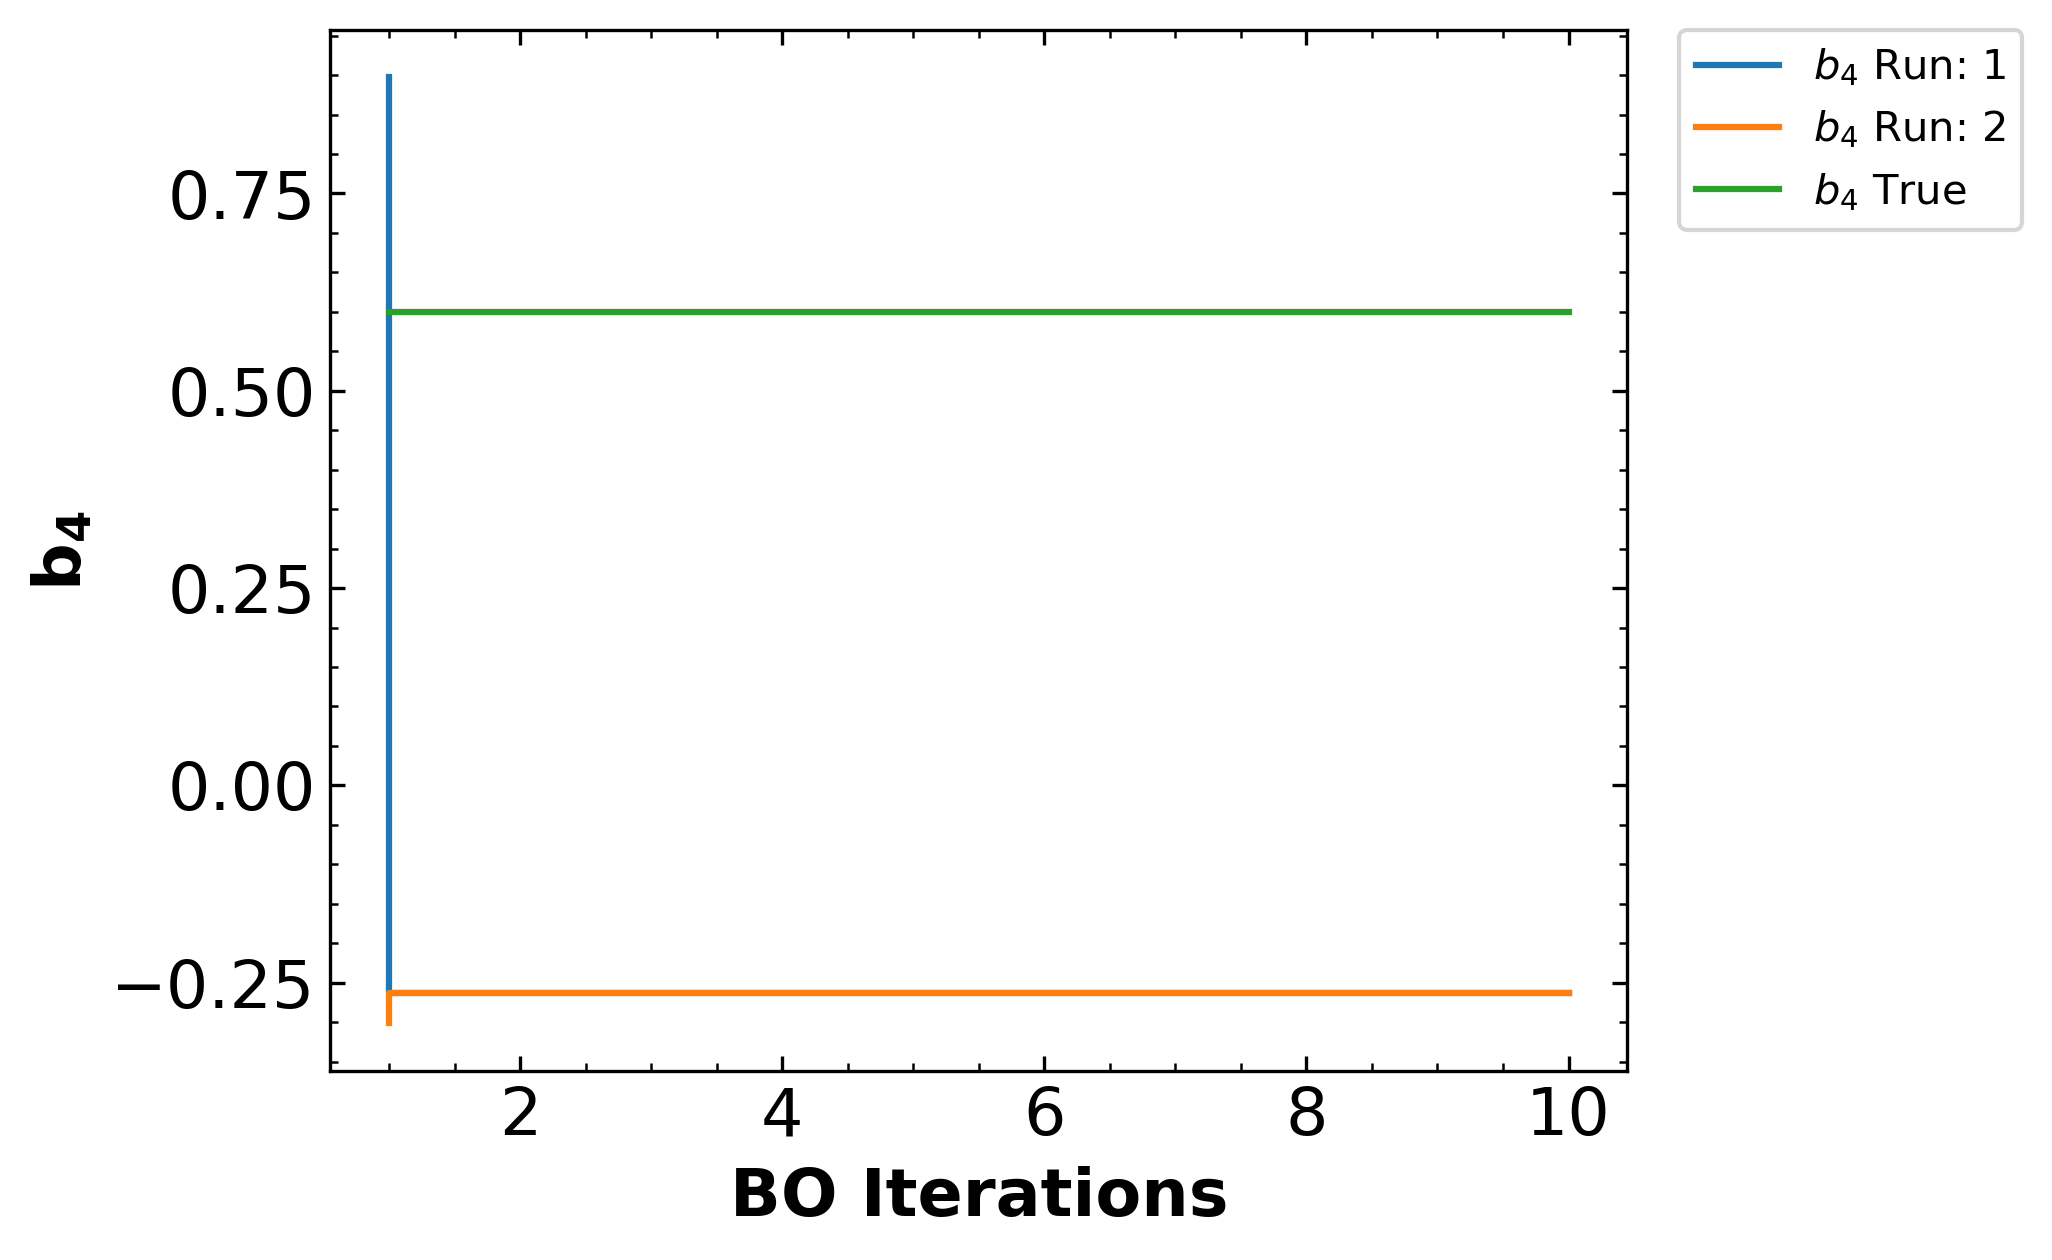

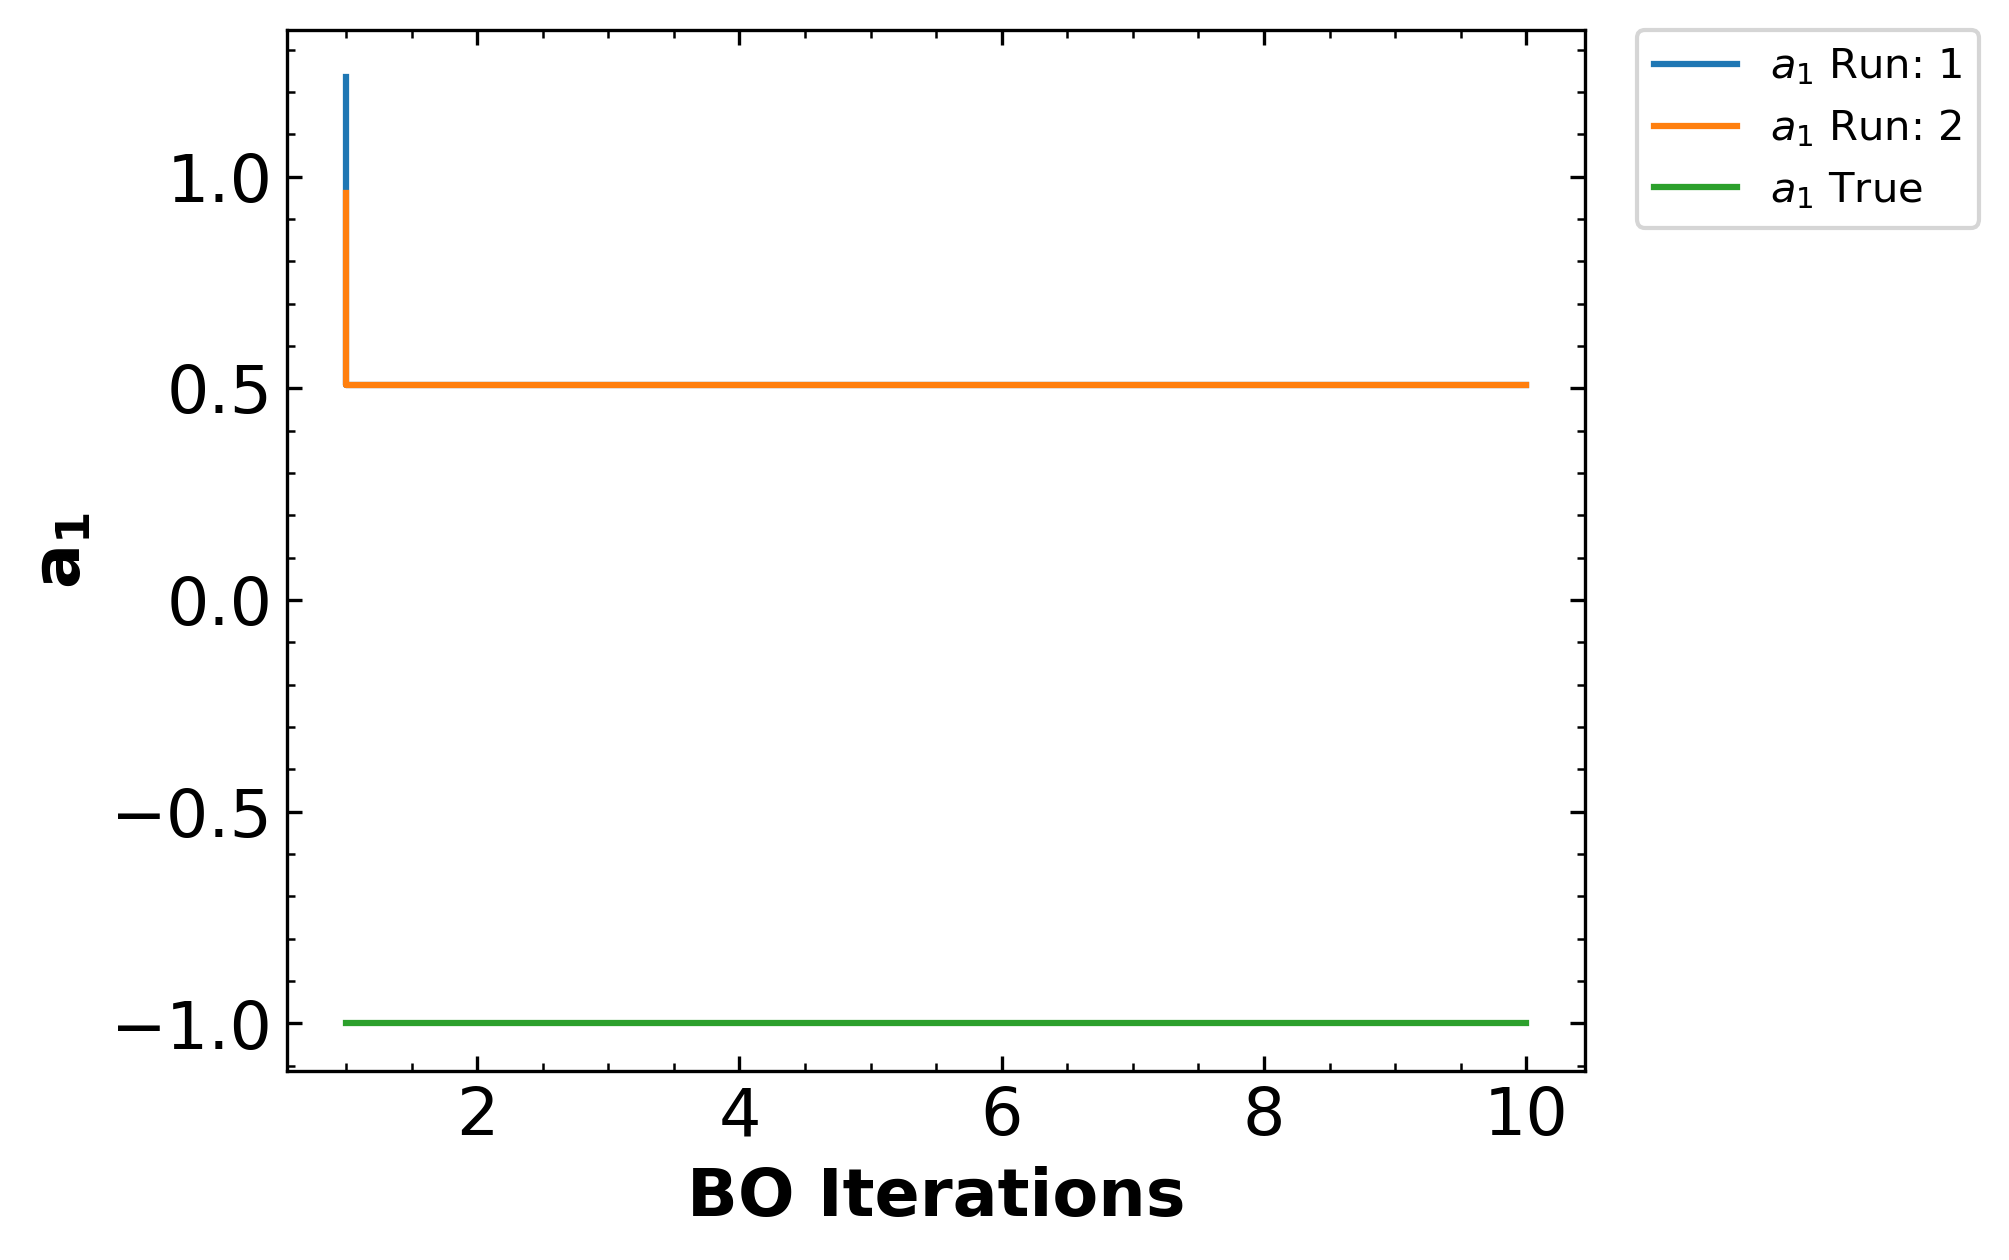

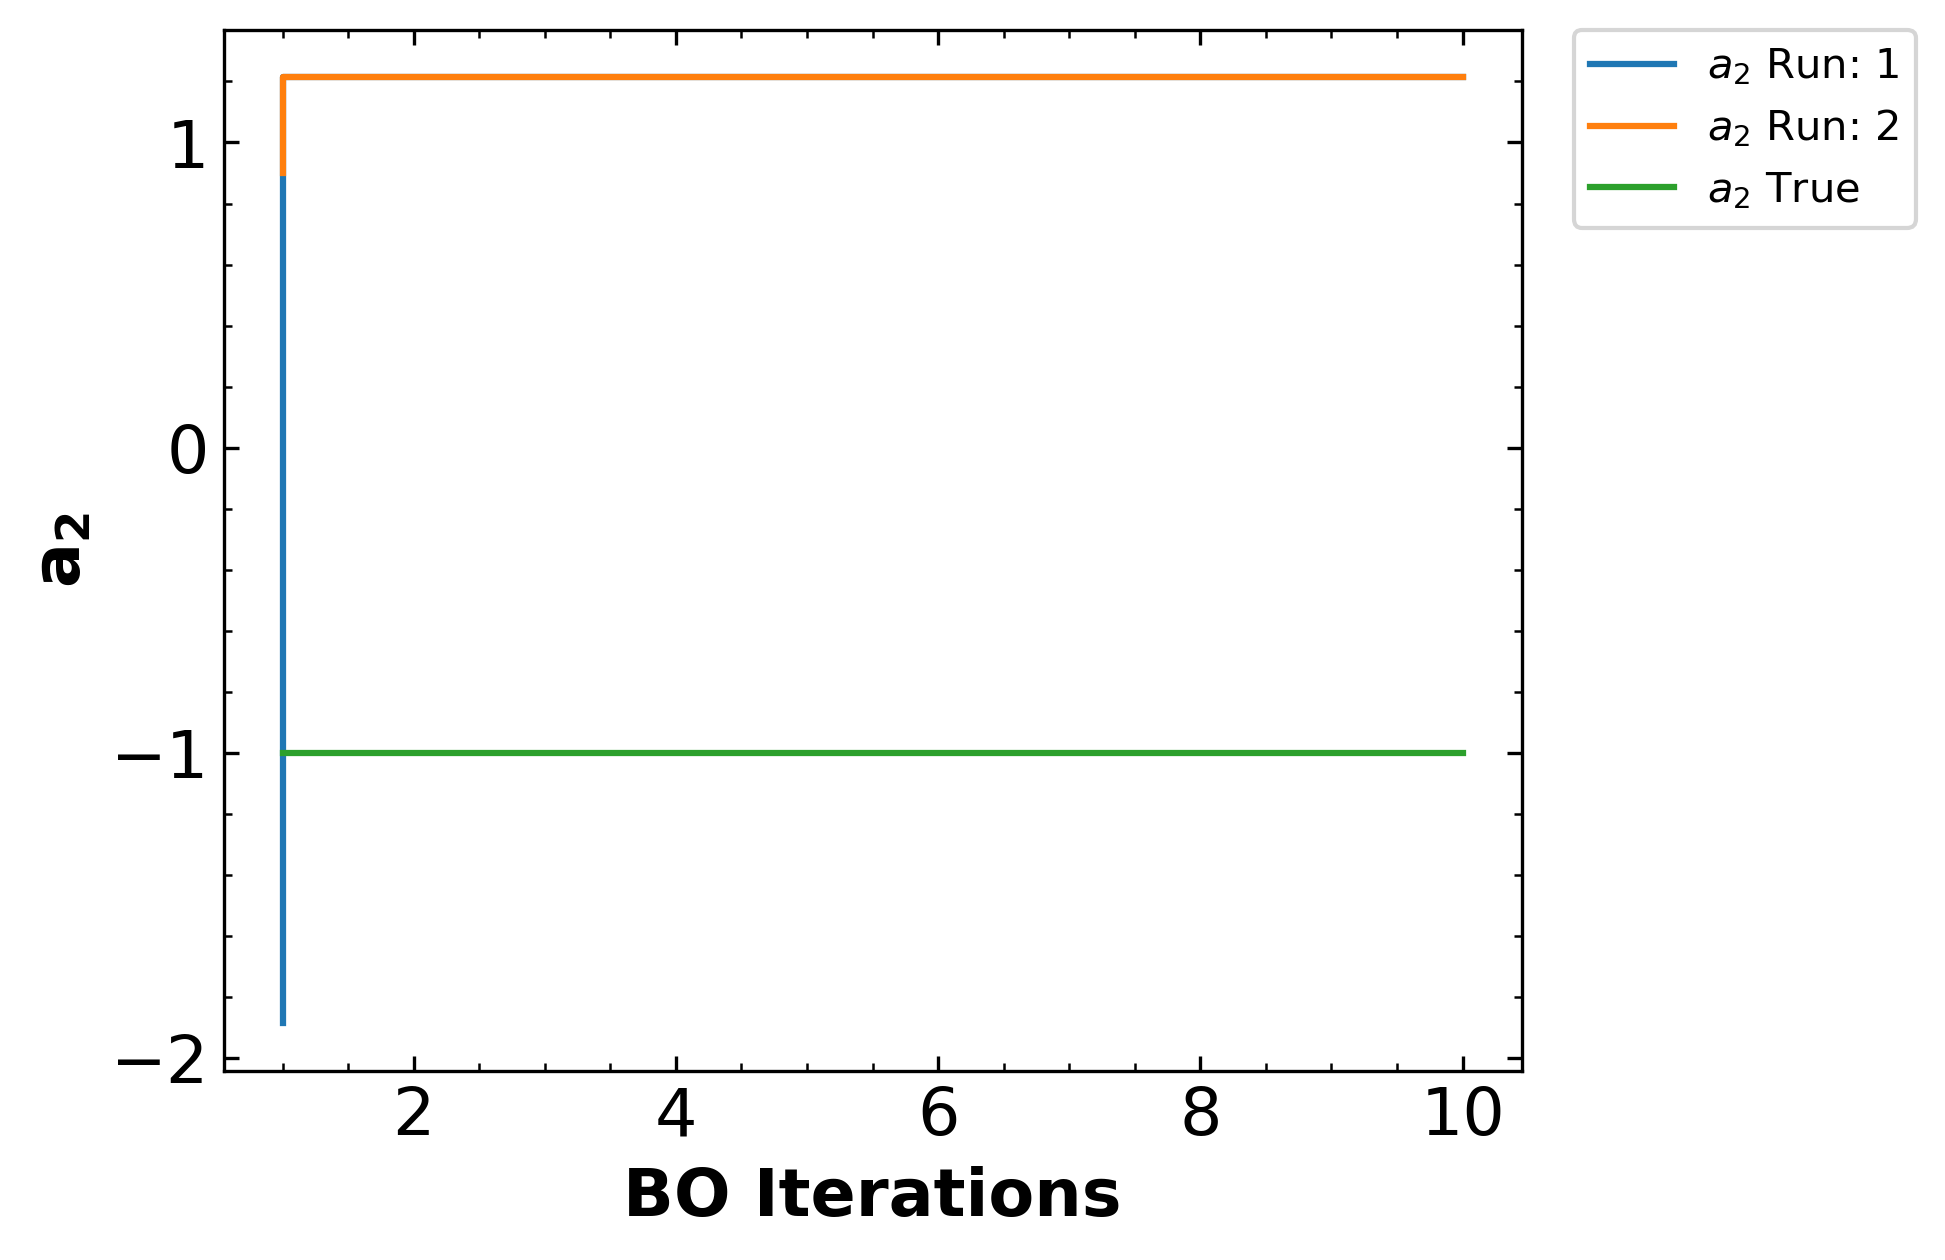

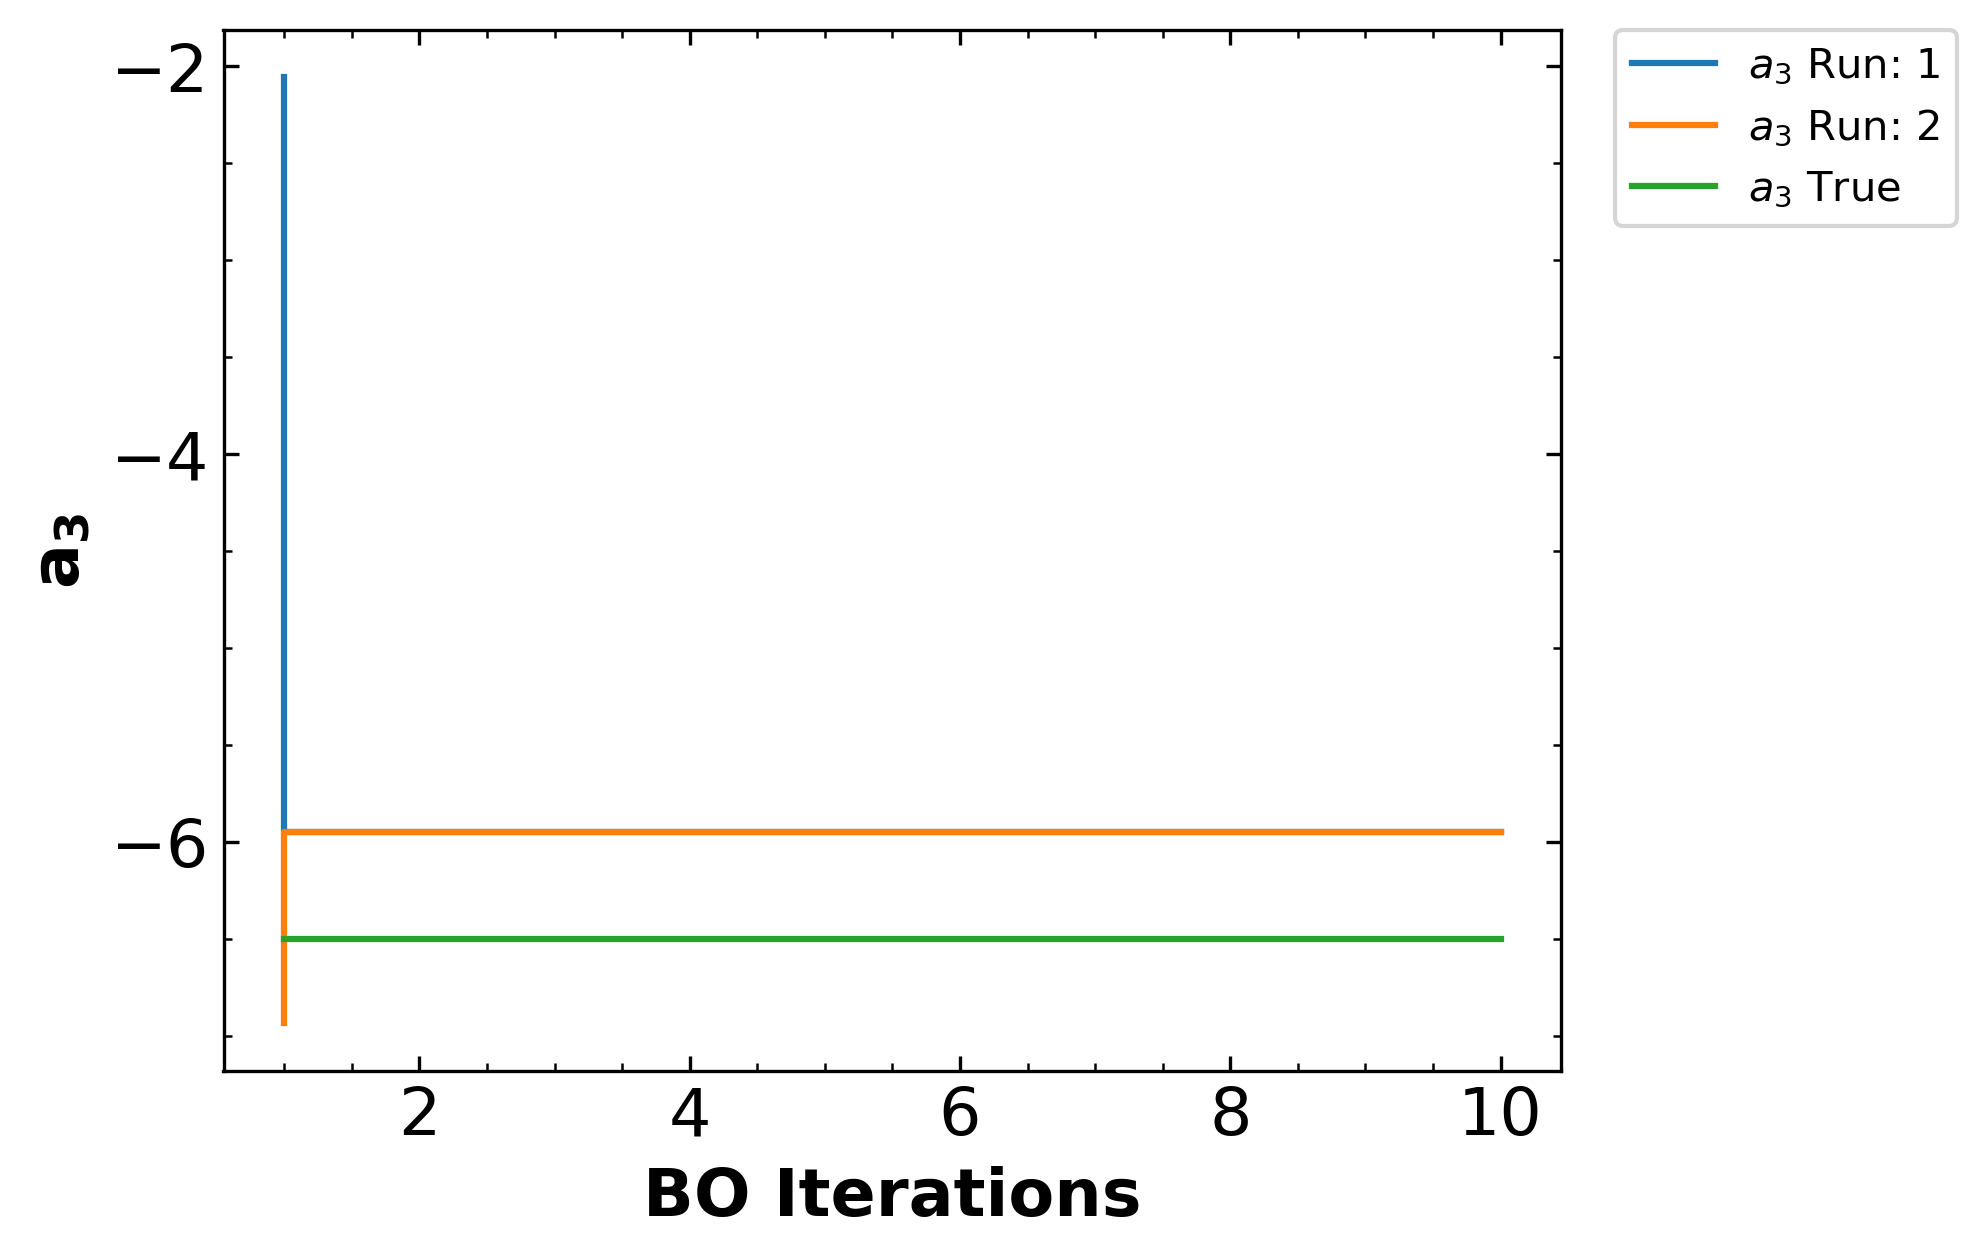

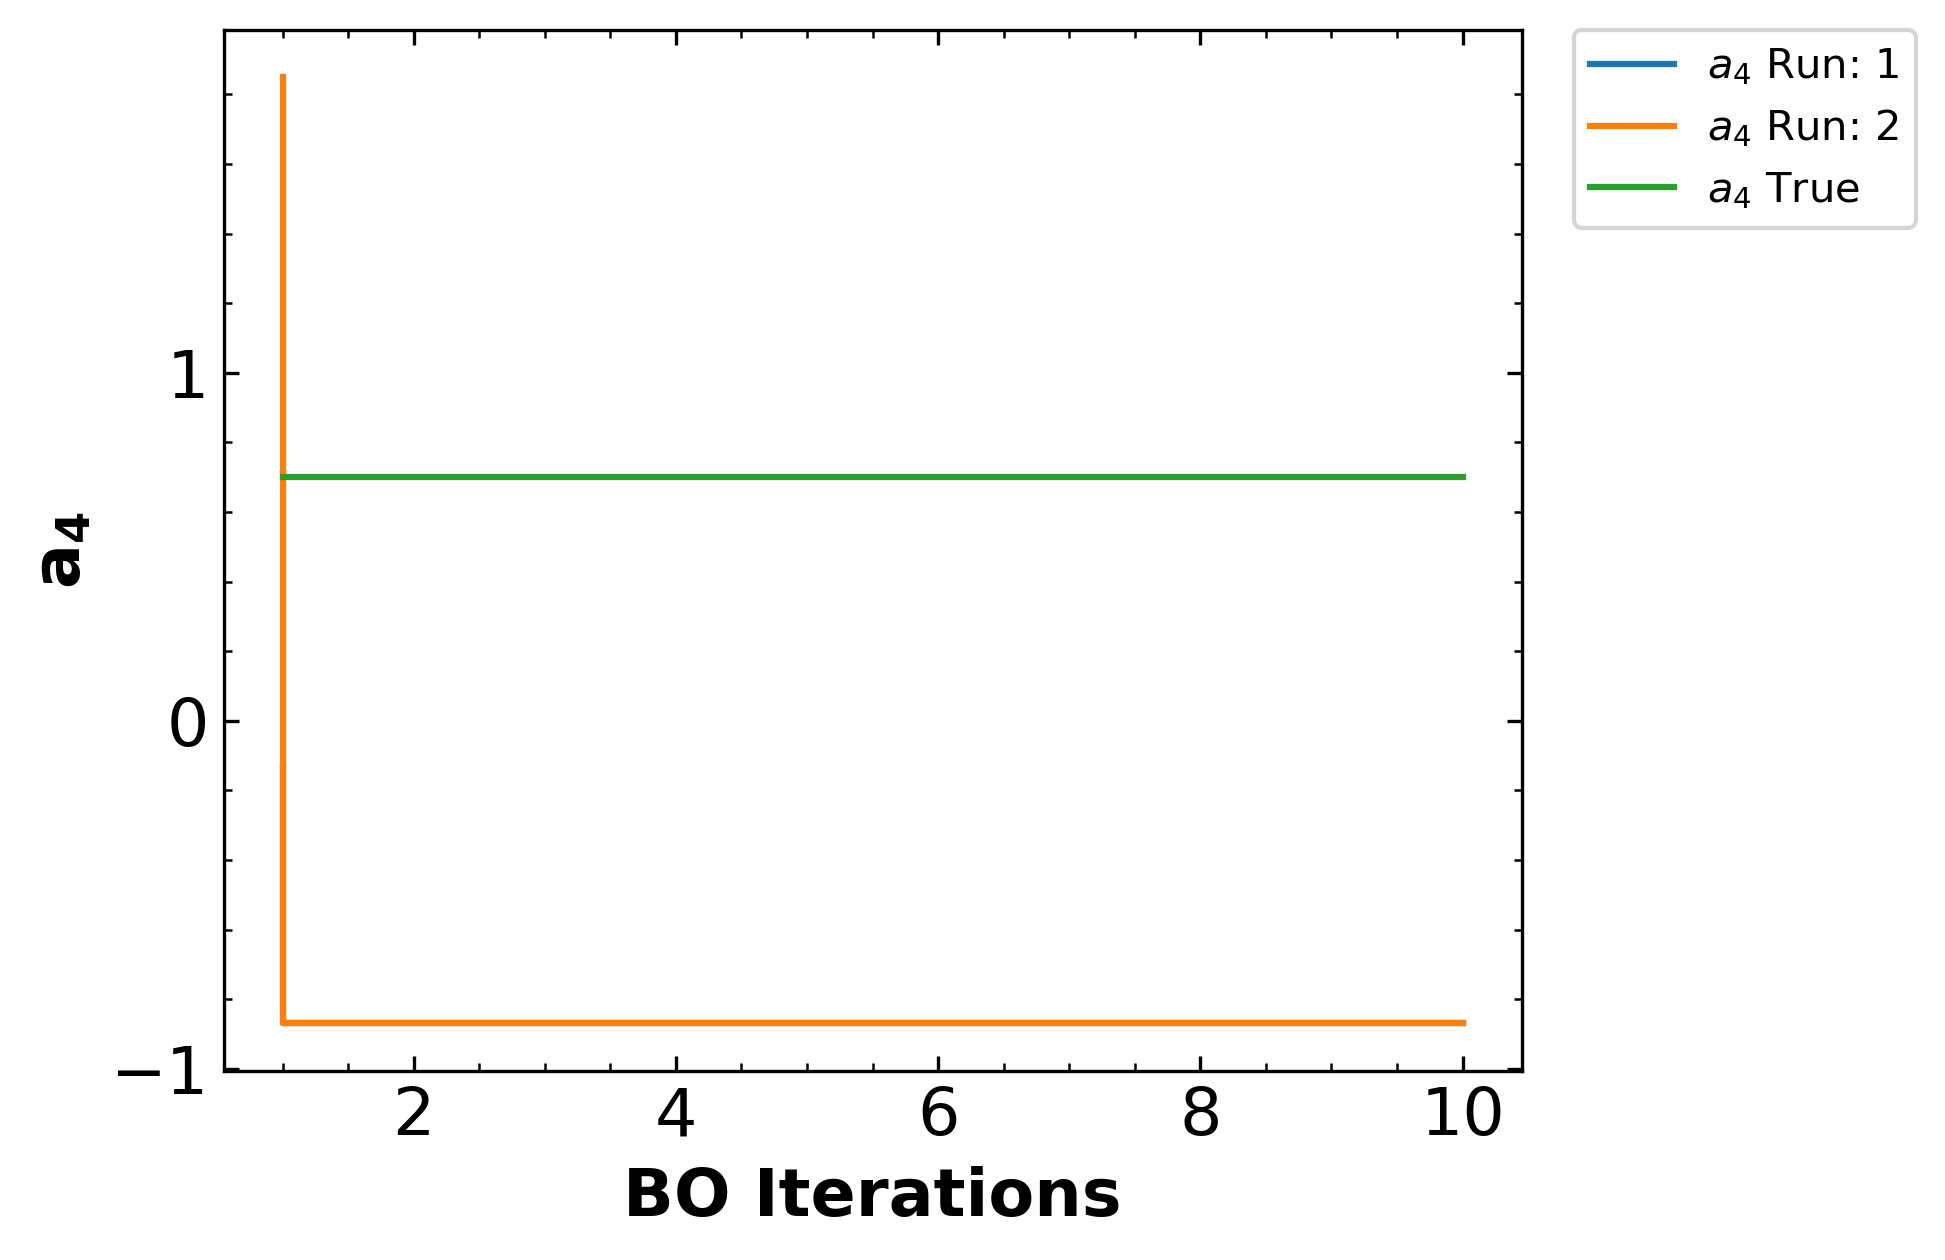

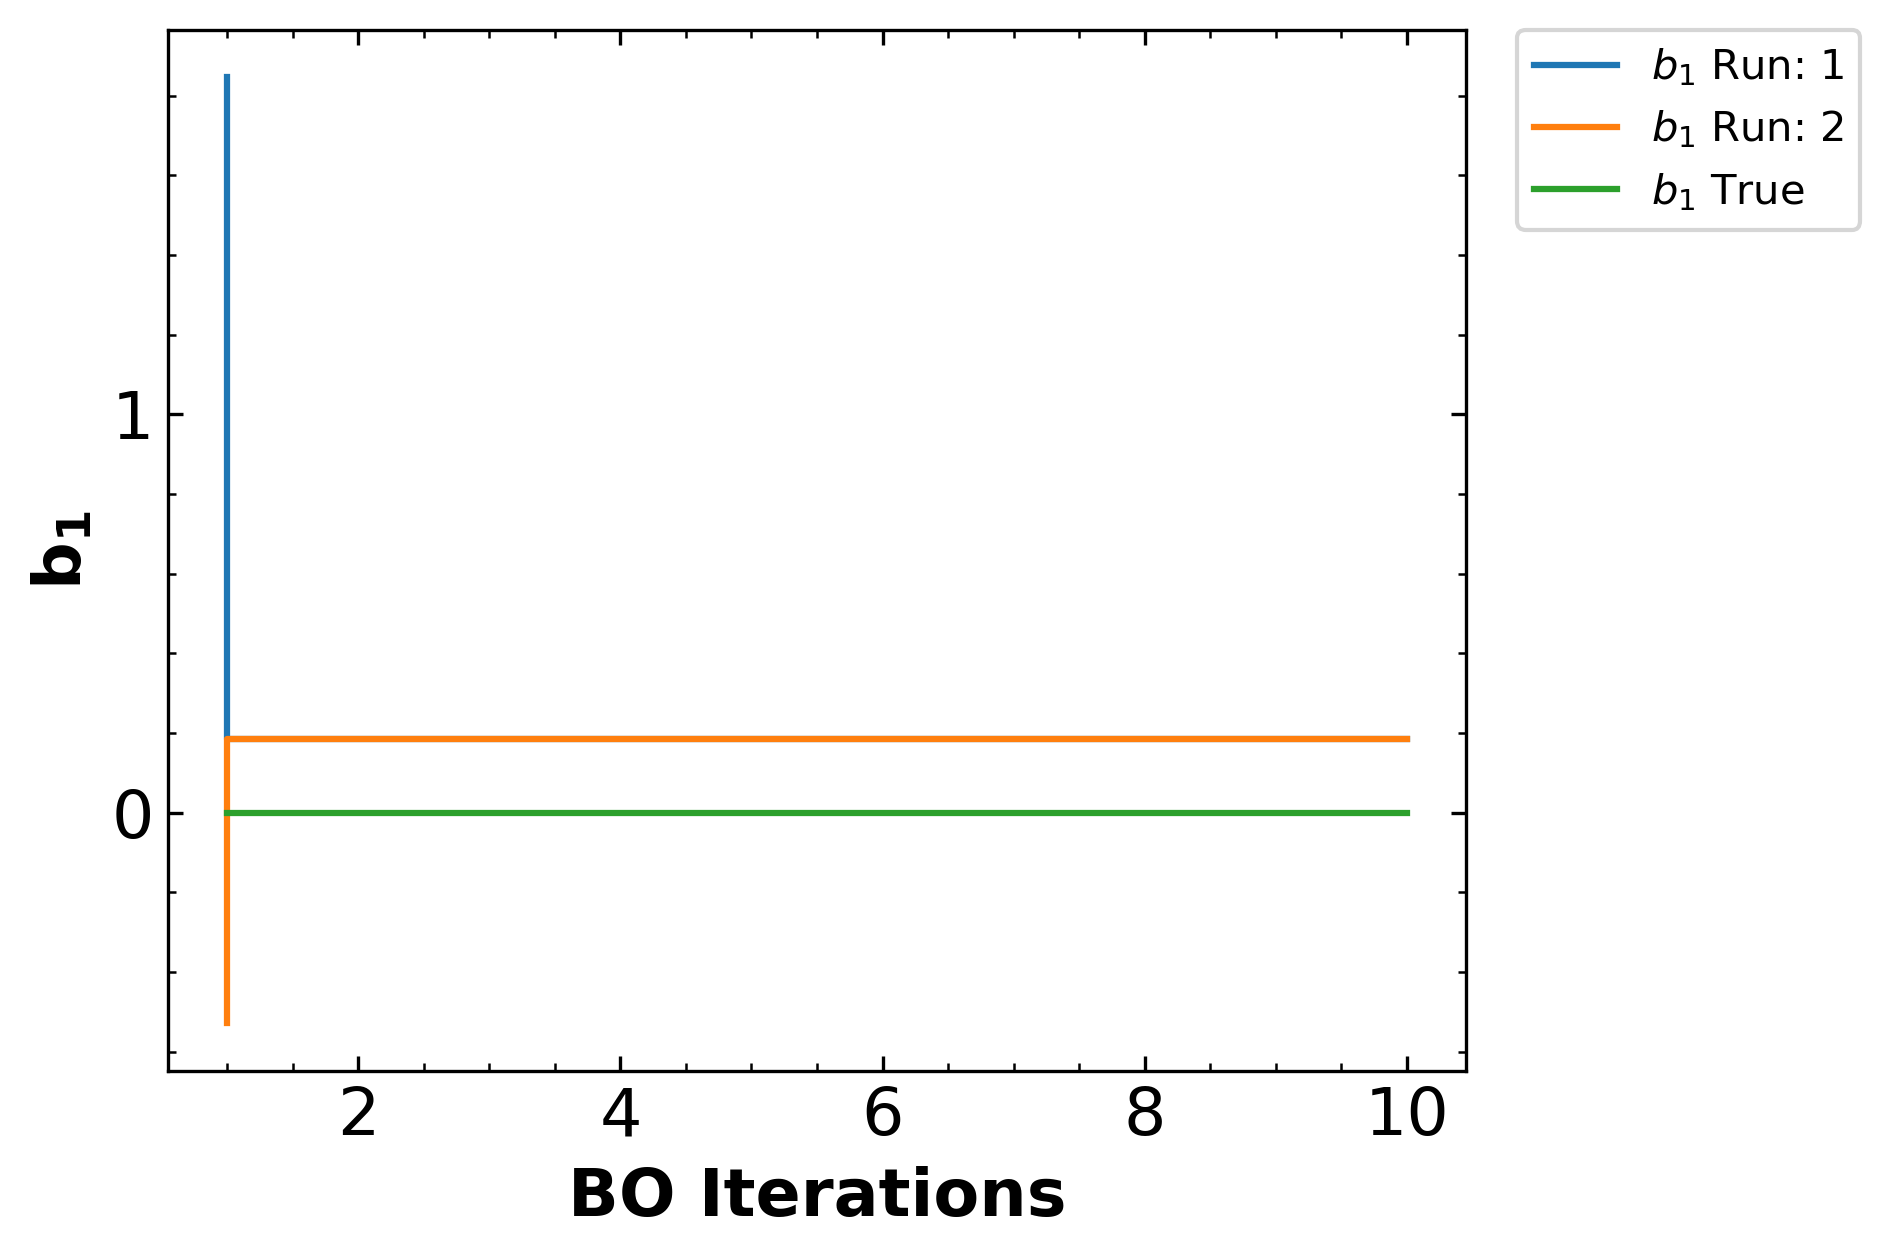

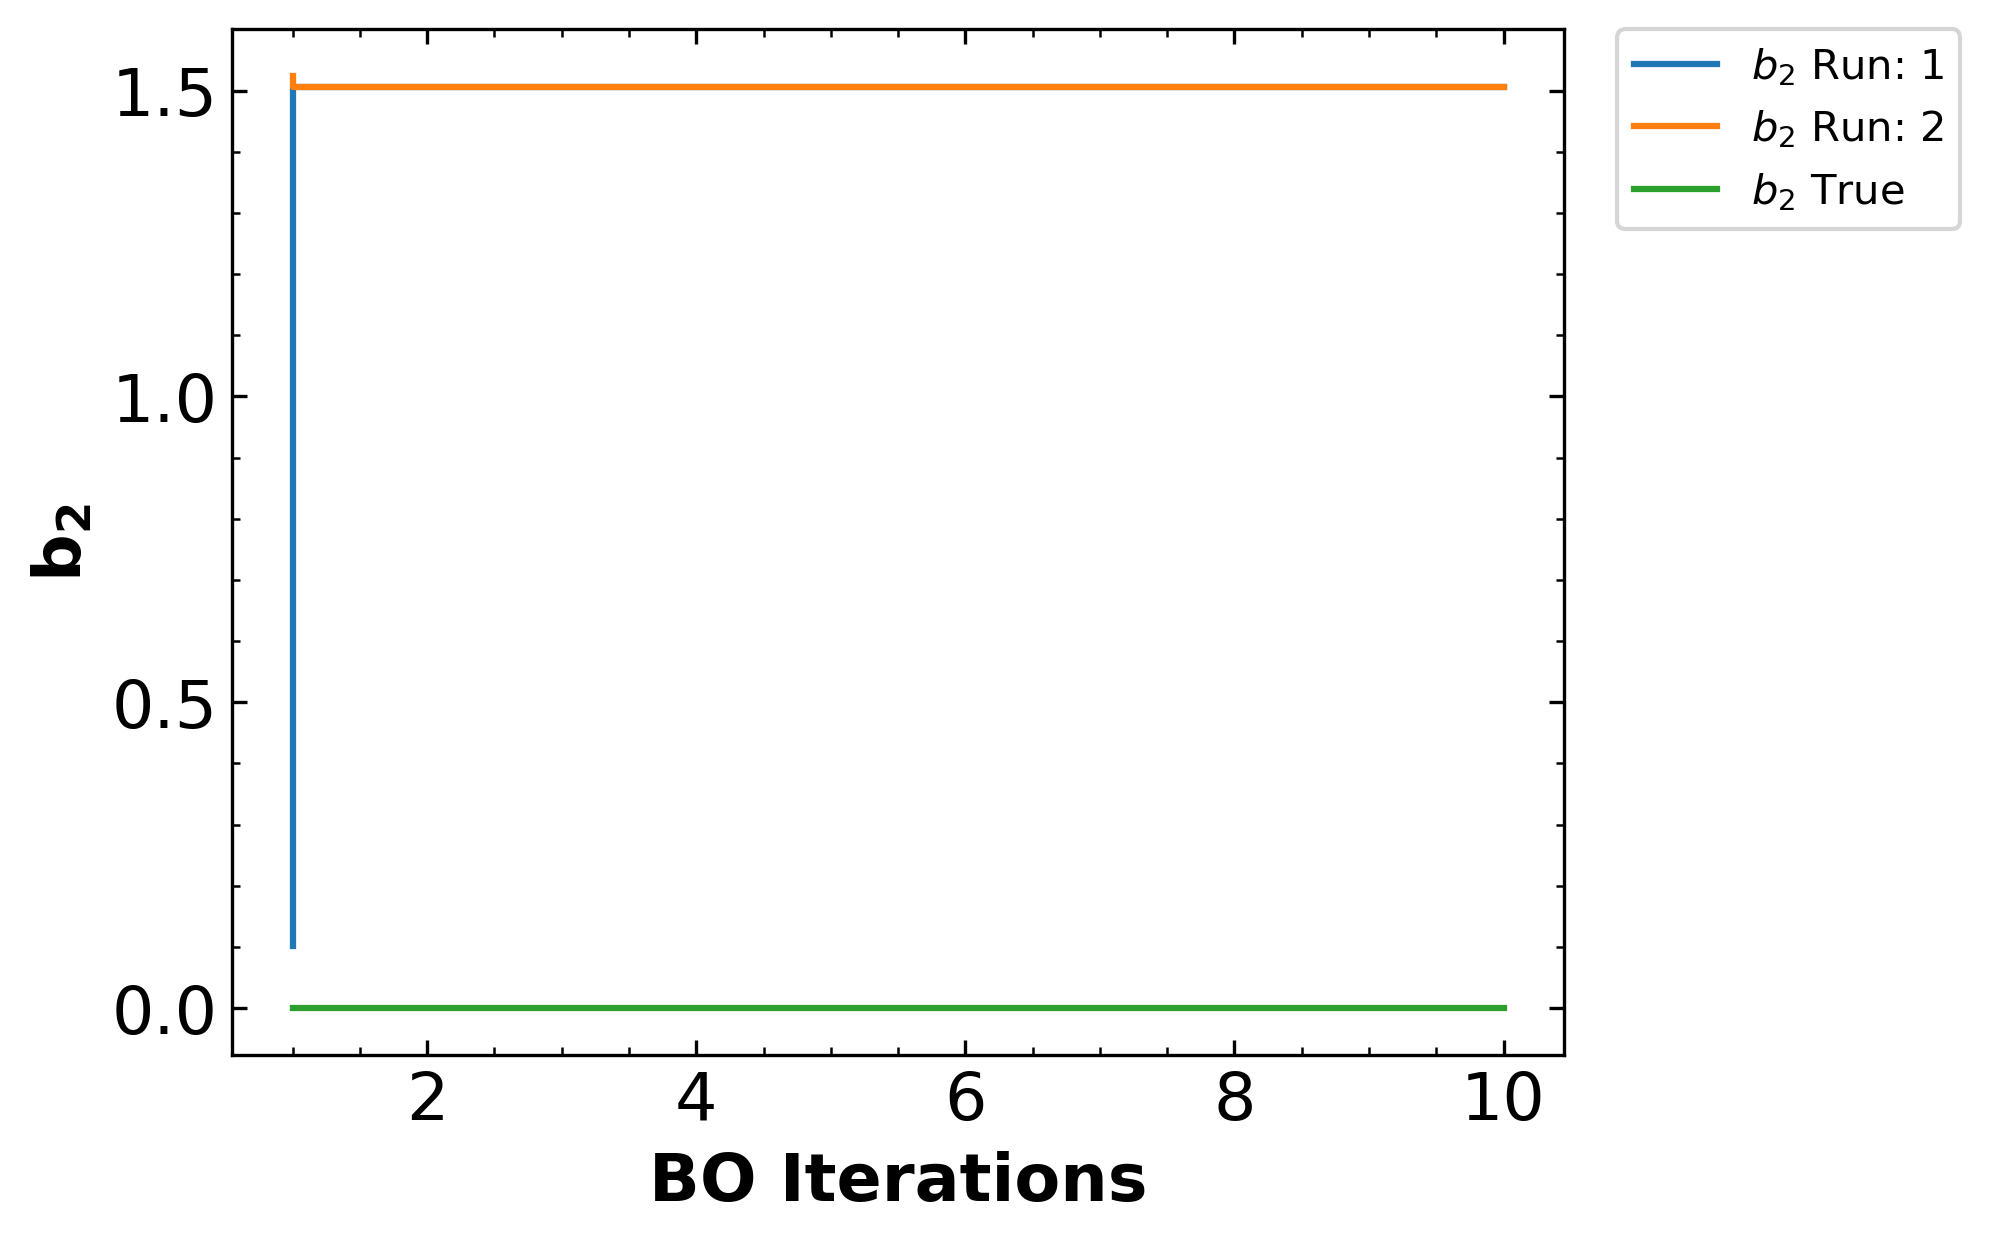

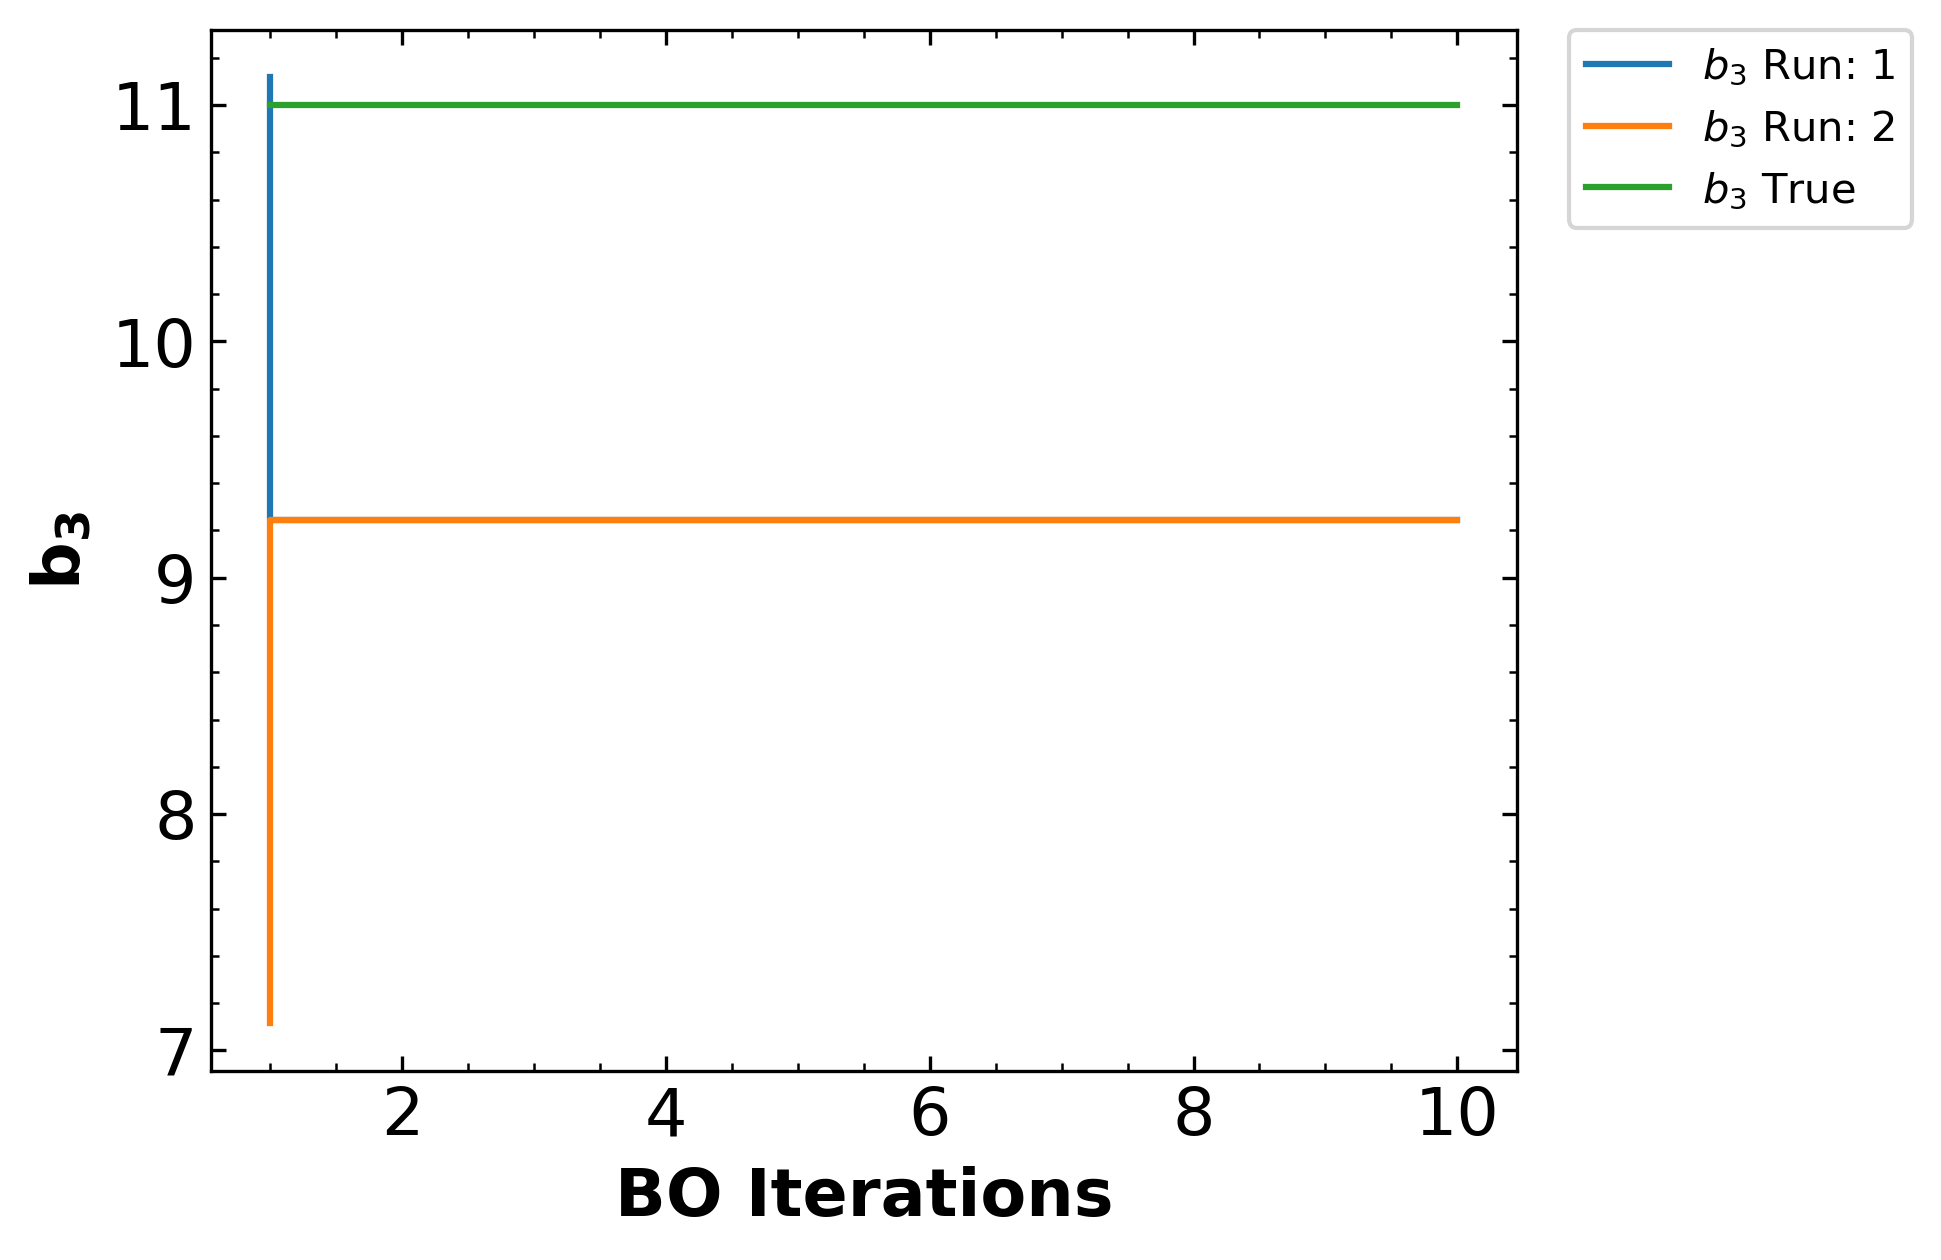

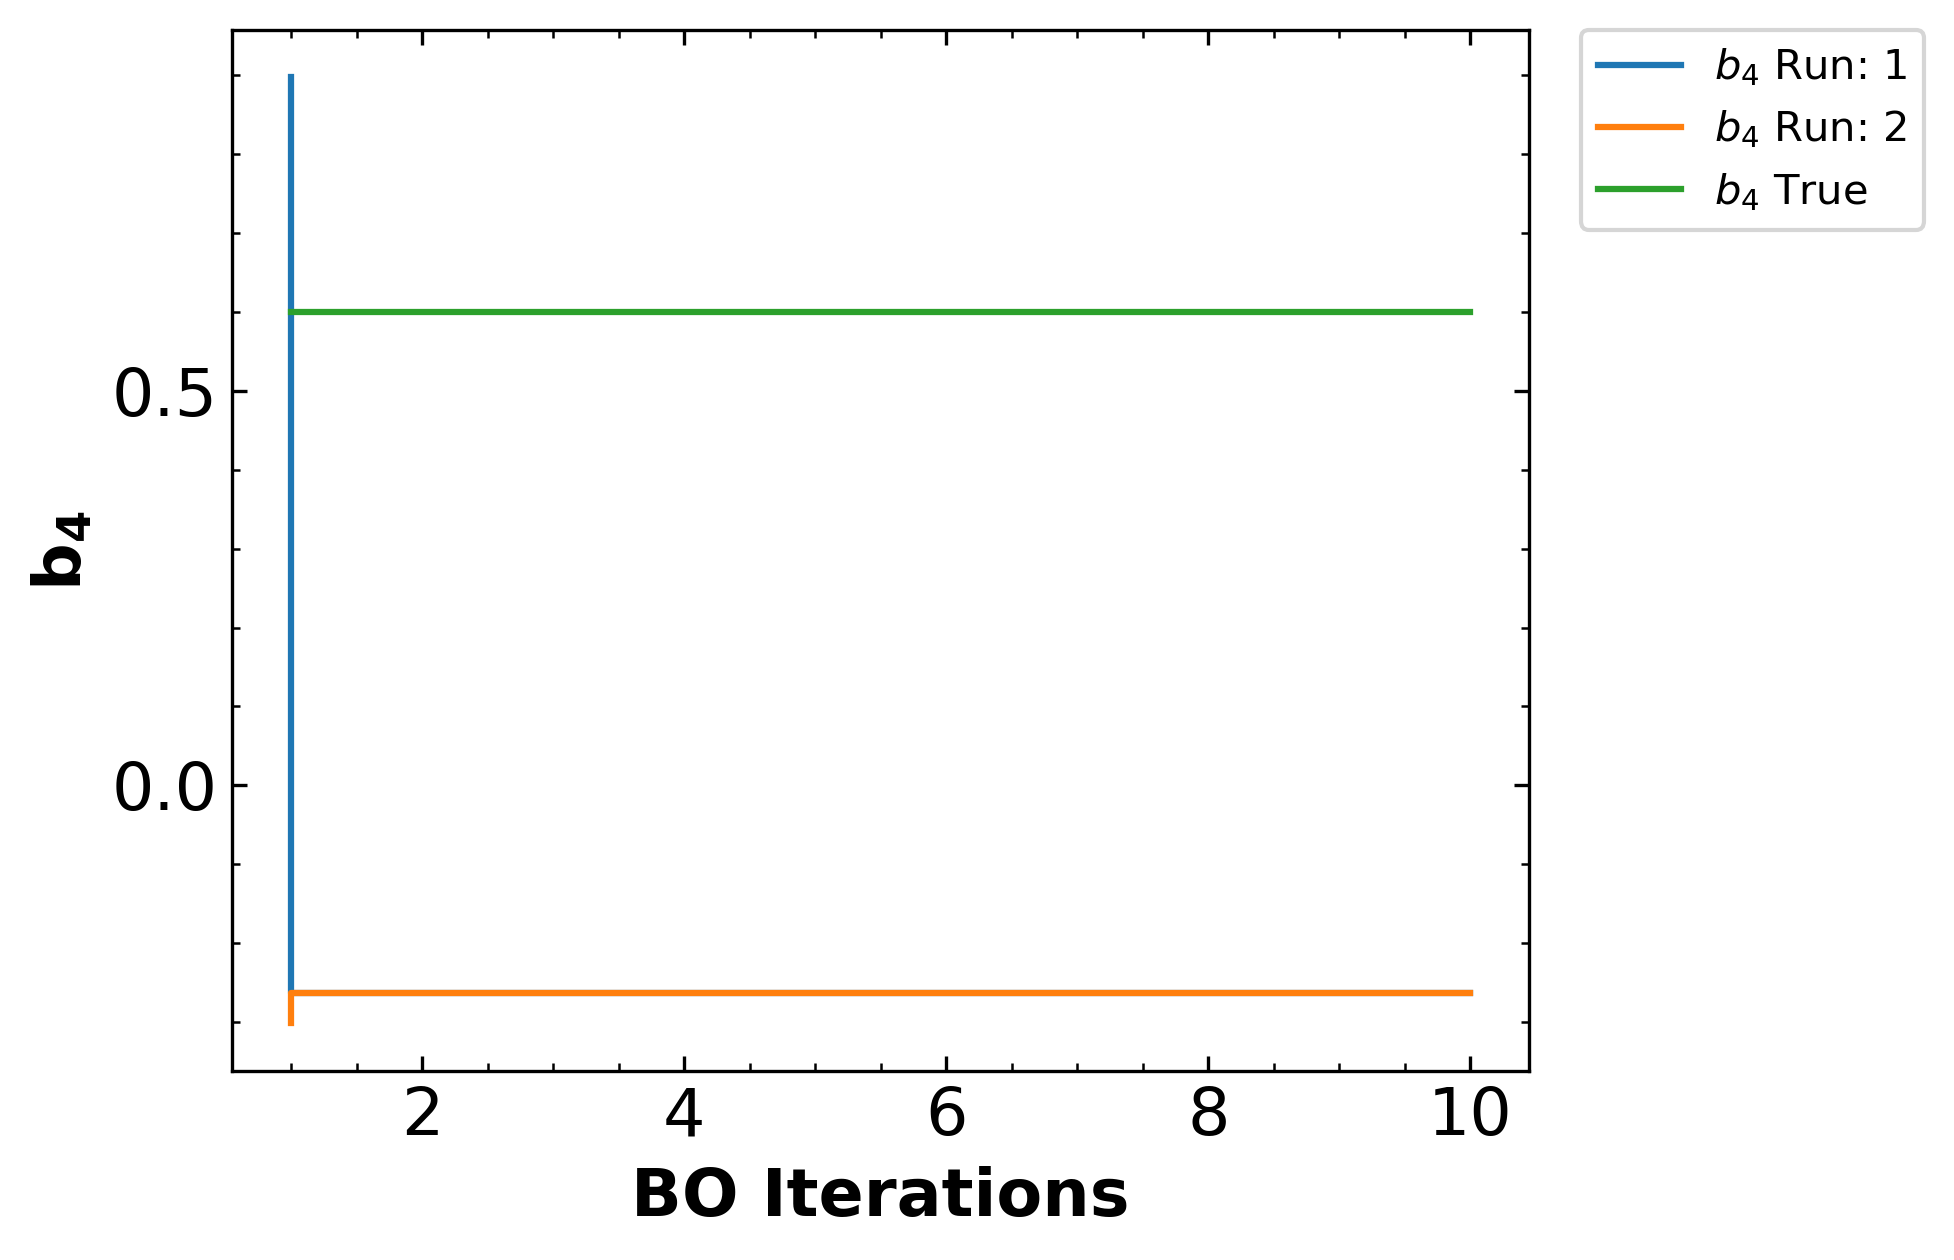

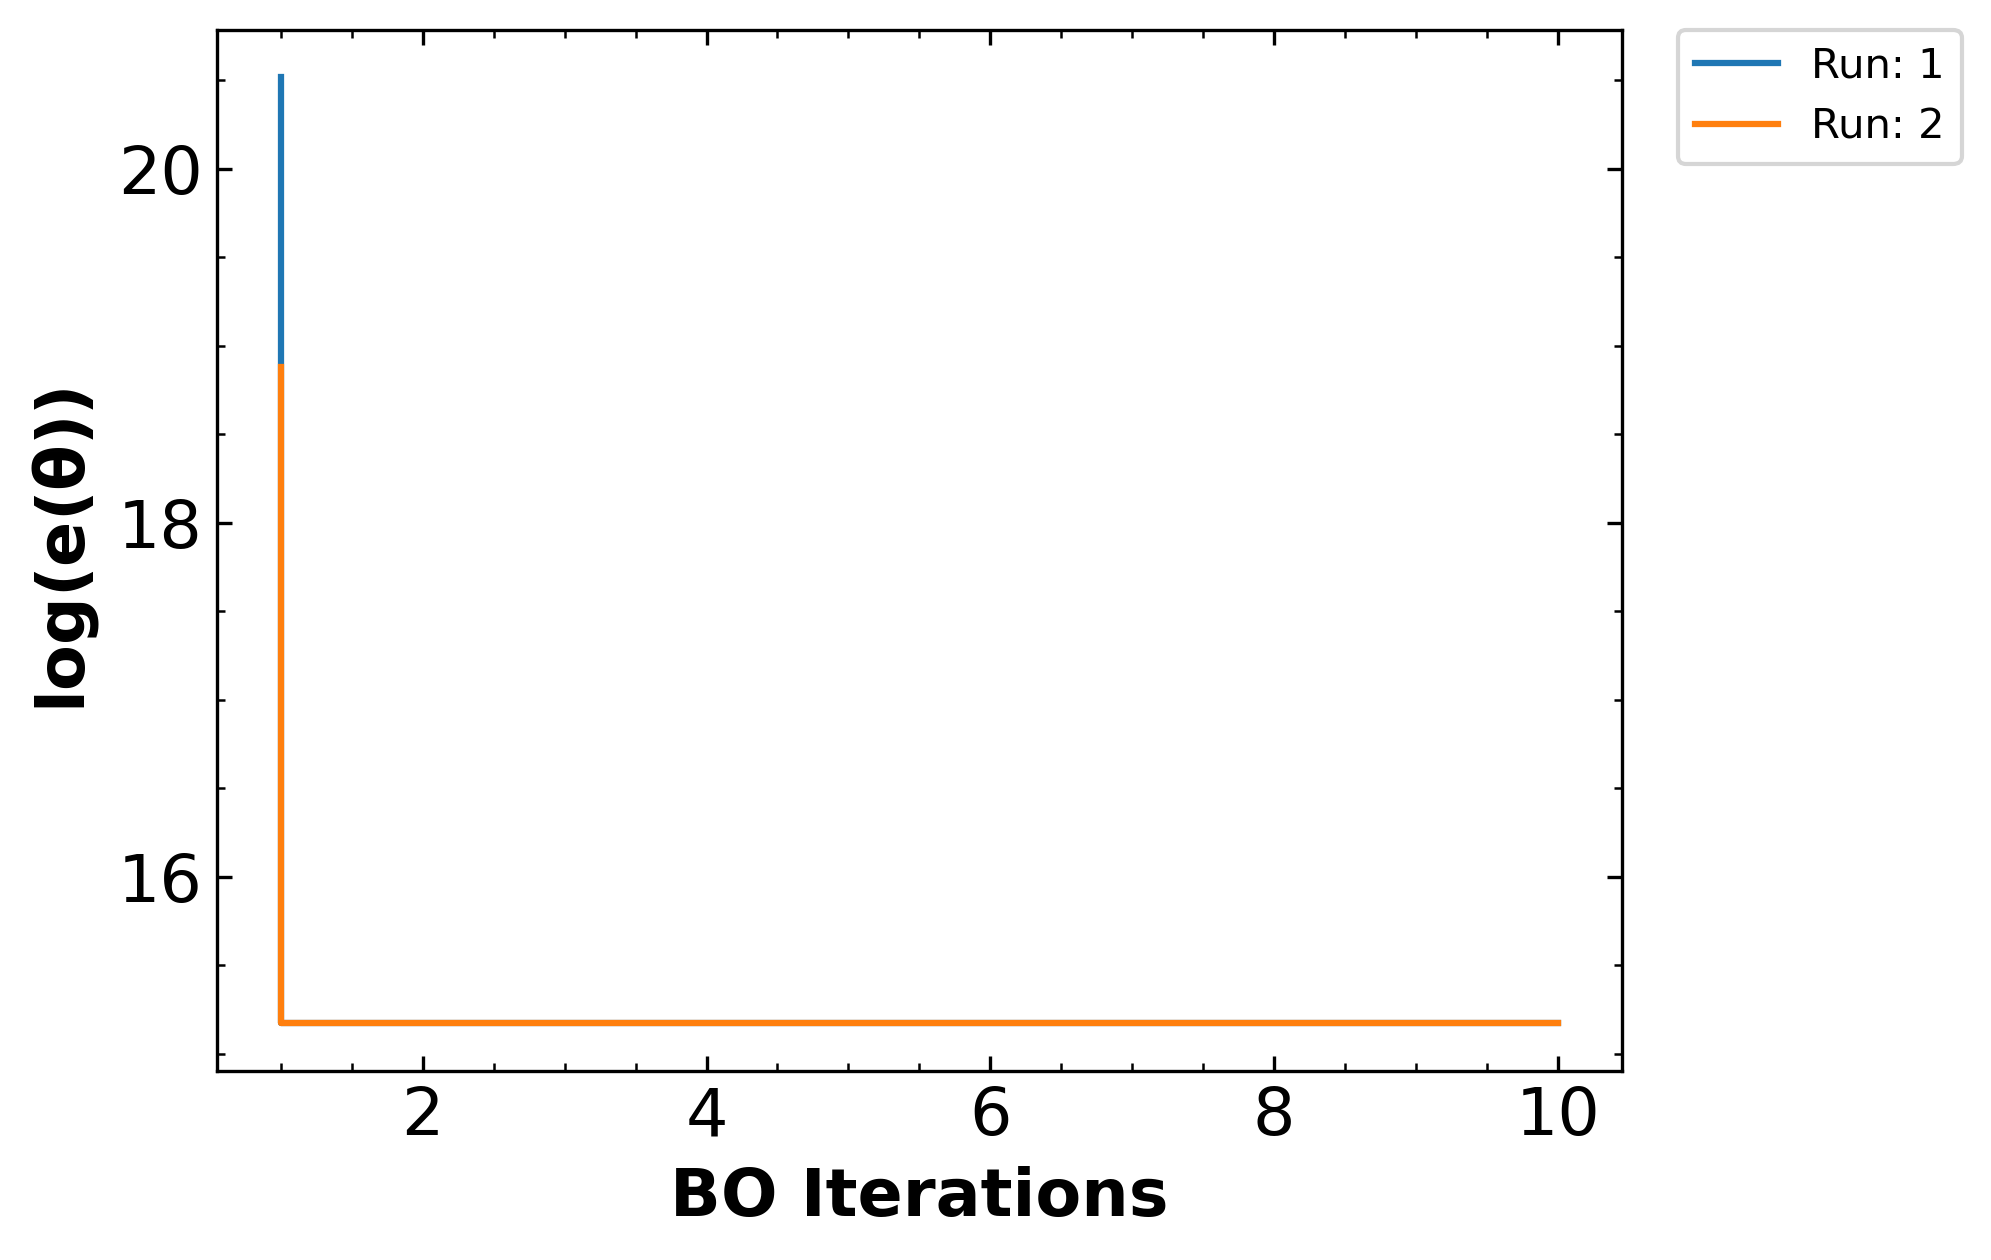

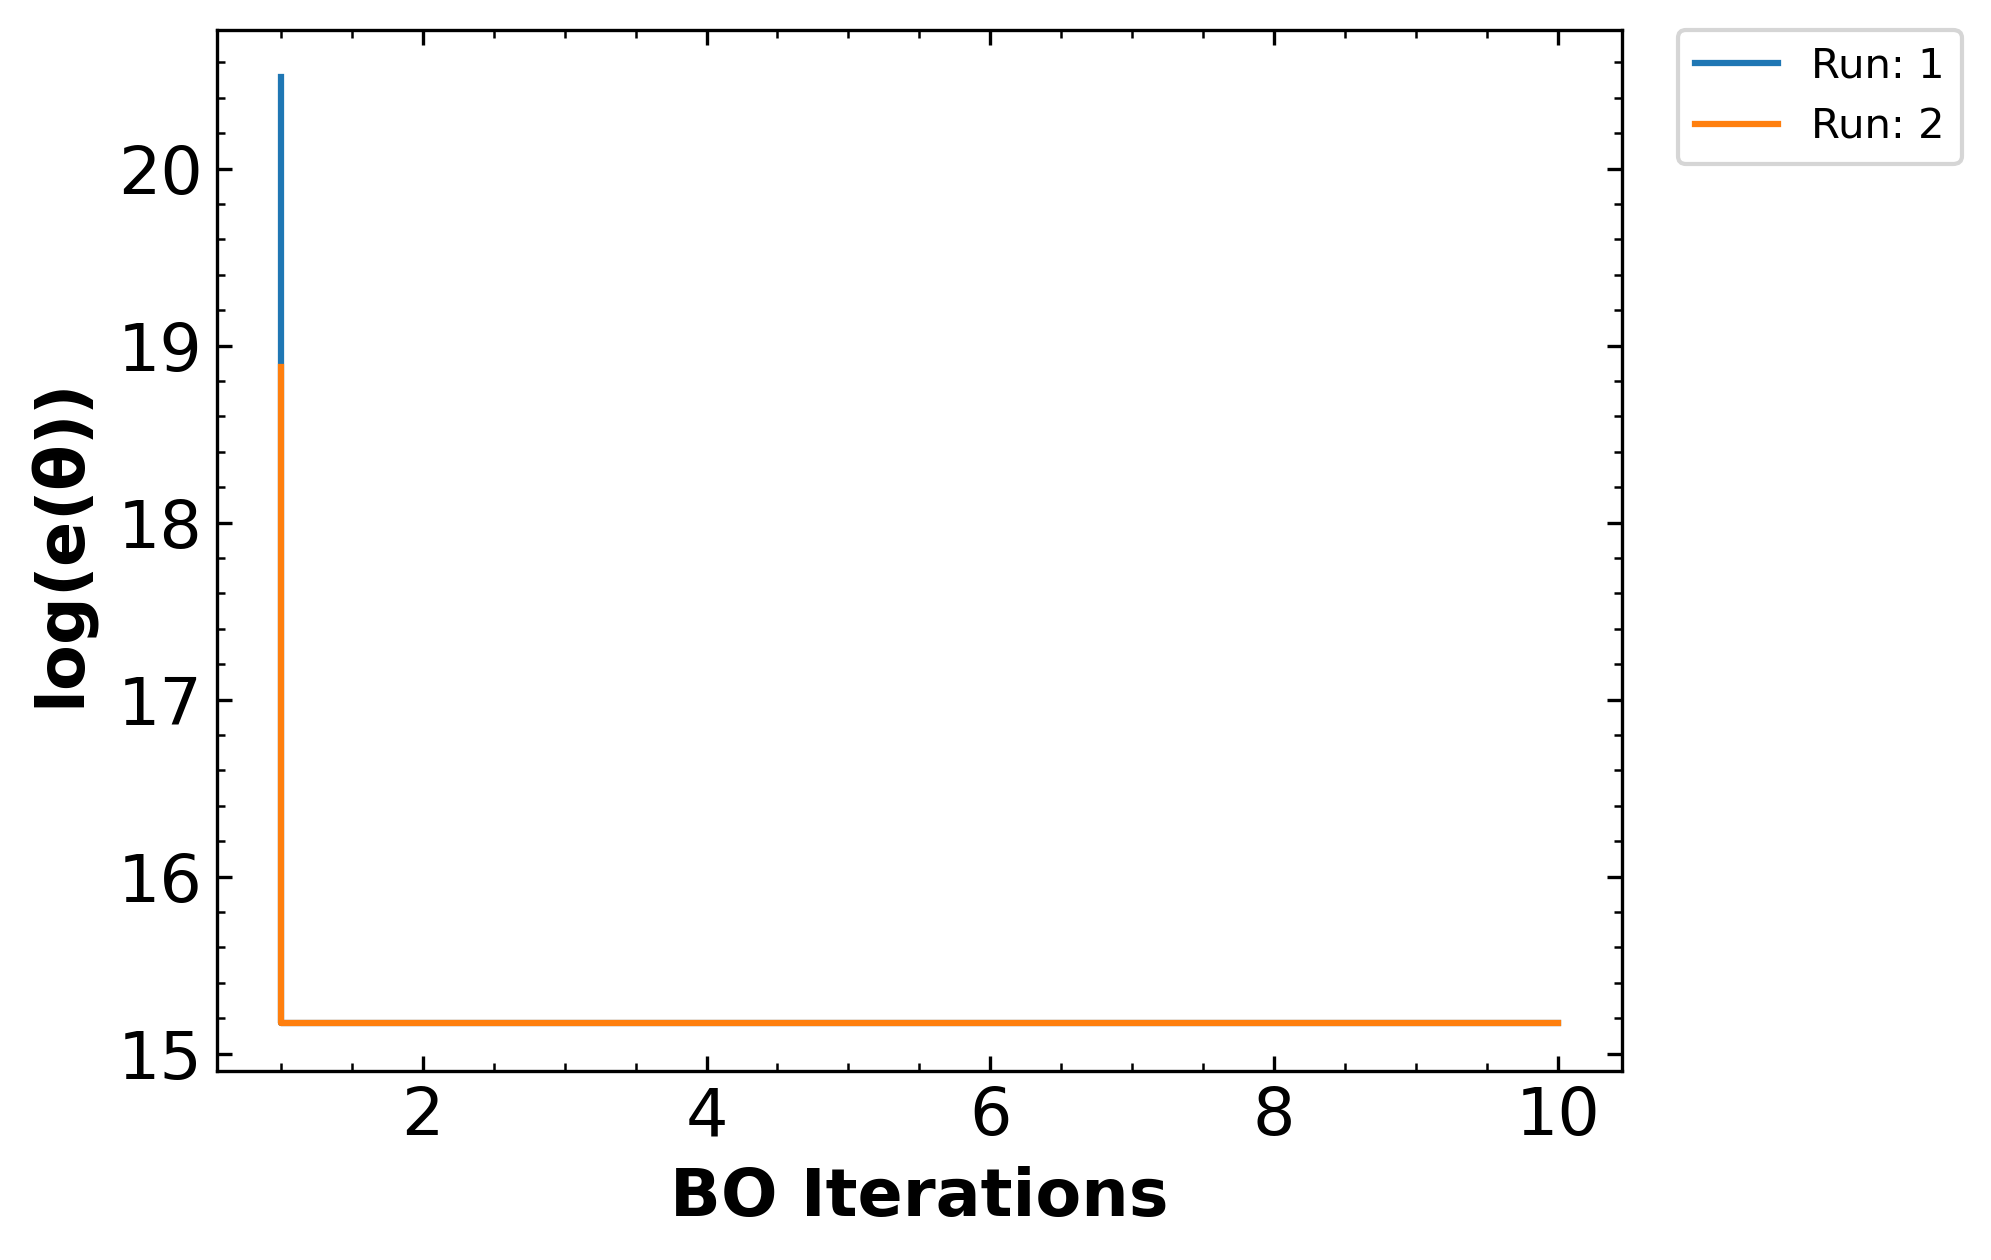

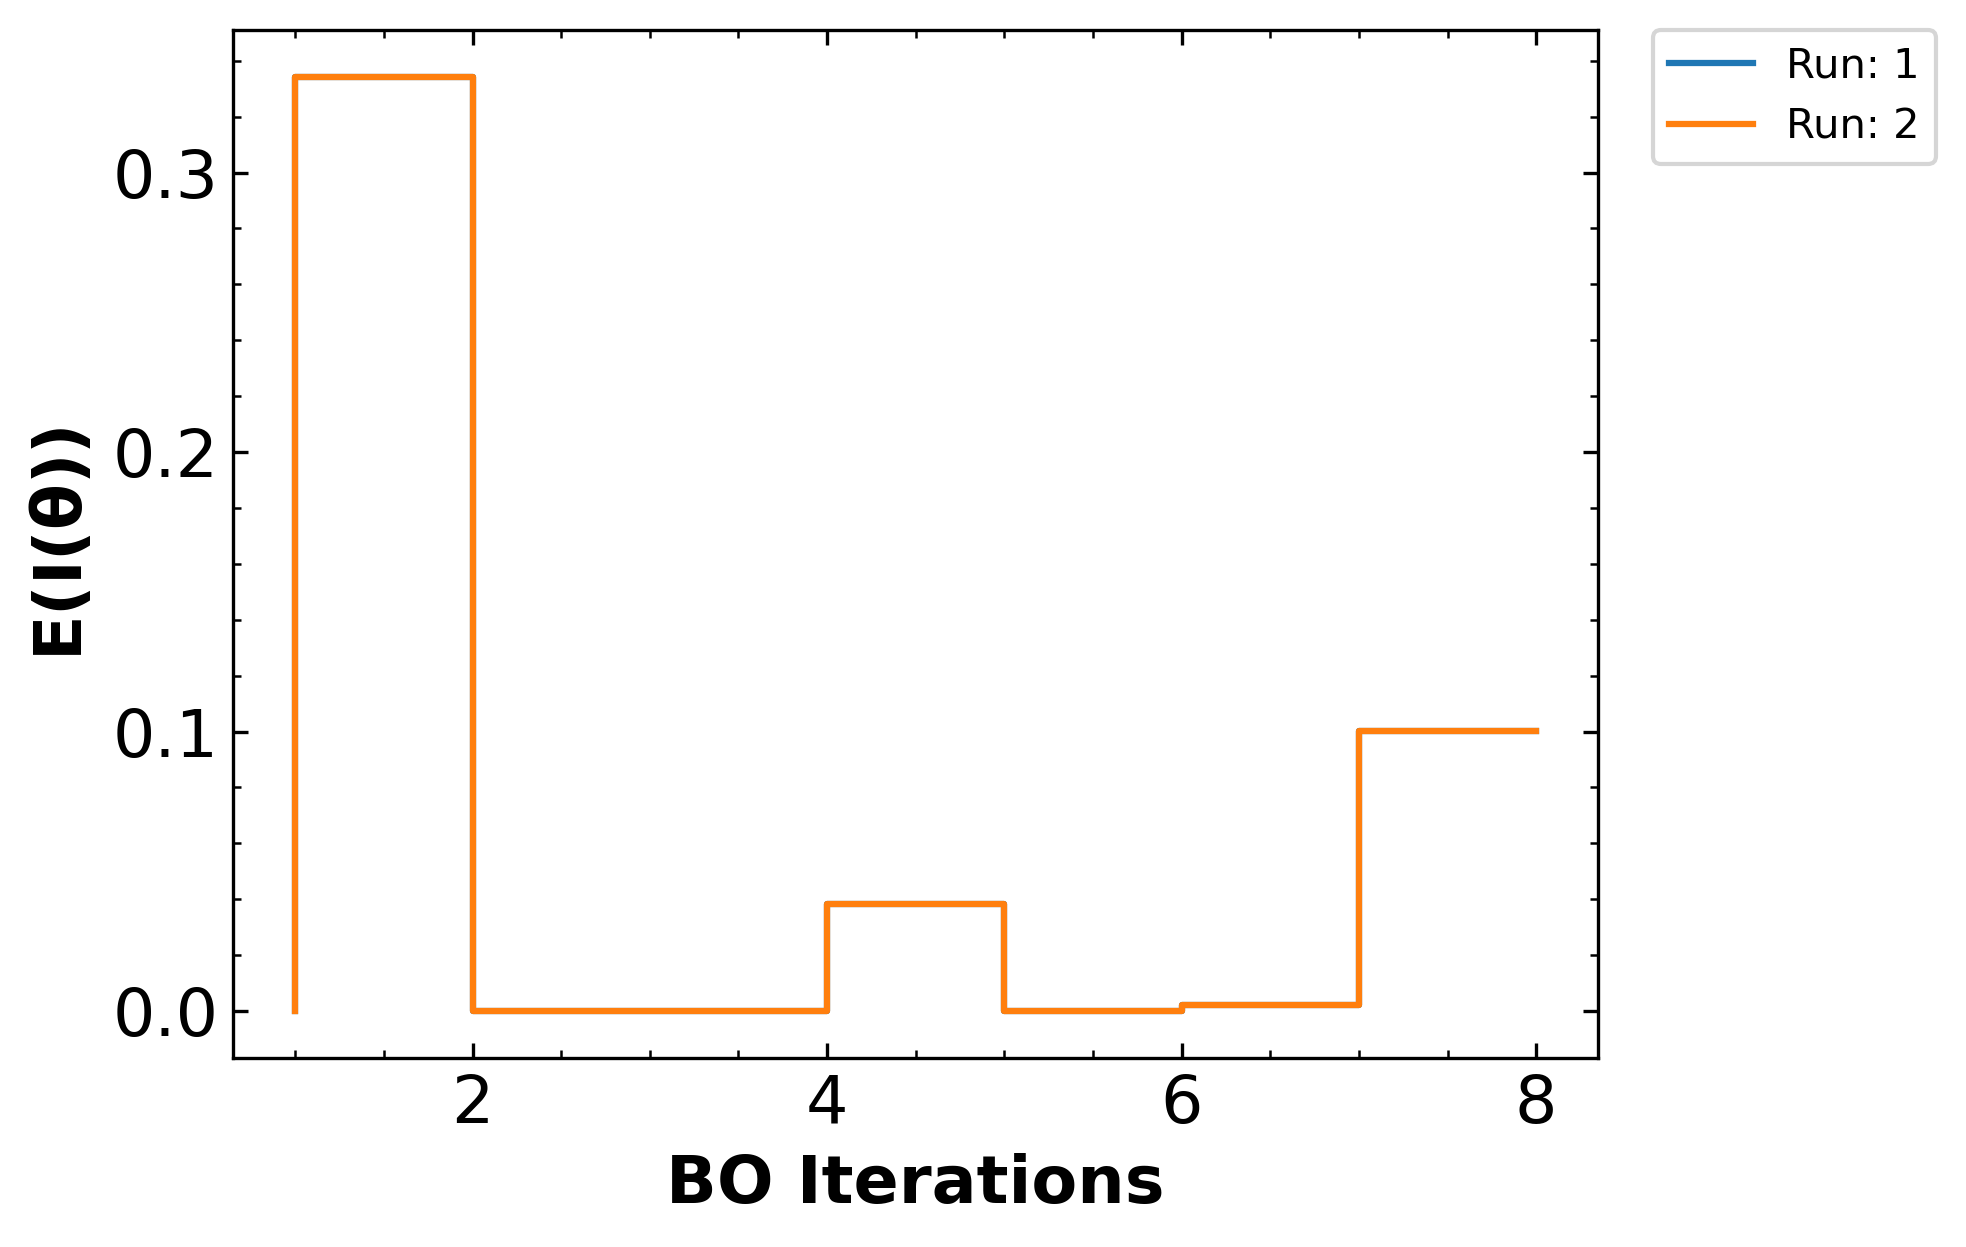

The GP predicts the lowest SSE of 3.877e+06 occurs at θ = [ 0.50691462  1.21362448 -5.94947636 -0.86984444  0.18582535  1.50616455
  9.2427969  -0.26261806] during run 1 at BO iteration 3
At this point, the highest EI occurs at θ = [ 1.17437434  1.72360206 -0.29852092 -1.82245278 -1.86635526  0.20784426
  9.26623344 -1.92853492]


[-1.  -1.  -6.5  0.7  0.   0.  11.   0.6]
CPU times: user 17.2 s, sys: 733 ms, total: 17.9 s
Wall time: 18.4 s


In [1]:
%%time

import sys
import gpytorch
import numpy as np
import pandas as pd
import torch
from datetime import datetime
from scipy.stats import qmc

import bo_methods_lib
from bo_methods_lib.bo_functions_generic import gen_theta_set, clean_1D_arrays
from bo_methods_lib.CS2_bo_functions_multi_dim import bo_iter_w_runs, find_train_doc_path, set_ep

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
#----------------------------------------------
CS = 2.2
Bound_Cut = True
denseX = True

#Set Date and Time
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d-%b-%Y (%H:%M:%S)")
print("Date and Time: ", timestampStr)
# DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M-%S%p")
DateTime = dateTimeObj.strftime("%Y/%m/%d/%H-%M")
DateTime = None ##For Testing

#Set Parameters
#Need to run at a and b, need 2 arrays to test that this will work
Constants = np.array([[-200,-100,-170,15],
                      [-1,-1,-6.5,0.7],
                      [0,0,11,0.6],
                      [-10,-10,-6.5,0.7],
                      [1,0,-0.5,-1],
                      [0,0.5,1.5,1]])

skip_param_types = 1 #This is what changes for subpoint
true_p = Constants[skip_param_types:skip_param_types+2].flatten()
param_dict = {0 : 'a_1', 1 : 'a_2', 2 : 'a_3', 3 : 'a_4',
              4 : 'b_1', 5 : 'b_2', 6 : 'b_3', 7 : 'b_4'}
exp_d = 2

if Bound_Cut == True:
    bounds_x = np.array([[-1.0, 0.0],
                        [   0.5, 1.5]])
    if denseX == True:
        n = 30
    else:
        n = 25 #Number of experimental data points to use
else:    
    bounds_x = np.array([[-1.5, -0.5],
                 [   1,    2]])
    n = 27 #Number of experimental data points to use
bounds_p = np.array([[-2, -2, -10, -2, -2, -2,  5, -2],
               [ 2,  2,   0,  2,  2,  2, 15,  2]])

d = len(true_p)
BO_iters = 10
runs = 2
train_iter = 300
noise_std = 0.01
shuffle_seed = 9
sep_fact = [1]
set_lengthscale = 1
explore_bias = 1

skip_param_types = 1
eval_all_pairs = True
eval_all_pairs = False
package = "scikit_learn"
kernel = "Mat_52"
outputscl = True 
initialize = 1

obj = np.array(["LN_obj"])
# obj = np.array(["obj"])
# obj = np.array(["obj","LN_obj"])
# emulator = False
emulator = np.array([False])
# emulator = np.array([True])
sparse_grid = np.array([False])
# sparse_grid = np.array([True])
norm = True
# norm = False
# sparse_grid = np.array([False,True])
verbose = False
# verbose = True
# save_fig = True
save_fig = False
save_CSV = False

if Bound_Cut == True:
    cut_bounds = '_cut_bounds'
else:
    cut_bounds = ""

if denseX == True:
    dense = "_dense"
else:
    dense = ""

#Pull Experimental data from CSV
exp_data_doc = 'Input_CSVs/Exp_Data/d='+str(exp_d)+'/n='+str(n)+cut_bounds+dense+'.csv'
exp_data = np.array(pd.read_csv(exp_data_doc, header=0,sep=","))
Xexp = exp_data[:,1:exp_d+1]
Yexp = exp_data[:,-1]
Xexp = clean_1D_arrays(Xexp)
# print(Xexp)
# print(Yexp)
#Define GP Testing space

LHS = True
p_train = 200
p=20
bounds_p = np.array([[-2, -2, -10, -2, -2, -2,  5, -2],
                   [ 2,  2,   0,  2,  2,  2, 15,  2]])
# Theta1 =  np.linspace(-2,2,p) #1x10
# Theta2 =  np.linspace(-2,2,p) #1x10
# theta_mesh = np.array(np.meshgrid(Theta1, Theta2)) #2 Uniform 5x5 arrays 
theta_mesh = gen_theta_set(LHS = LHS, n_points = p, dimensions = d, bounds = bounds_p)
print(len(theta_mesh))

print("Runs:", runs)
print("BO Iterations:",BO_iters)
print("%%%%%%%%%%%%%%%%%%%%%%%%%%")
for emul in emulator: 
    sys.stdout.flush()
    obj_use = obj
    print("-------------------")
    print("Emulator?:", emul)
    if emul == True: #Change this based on number of TP for each test
        t = p_train*n
        sparse_grid_use = sparse_grid
    else:
        t = p_train
        sparse_grid_use = np.array([sparse_grid[0]]) #Sparse Grid will always be False for 2-Input
        
    for sparse in sparse_grid_use:
#         #Can set ep to 1 for sparse grid if wanted
        if sparse == True:
            obj_use =  np.array(["obj"])
        else:
            obj_use =  obj
#             ep_use = torch.tensor([1]) 
#         else:
#             ep_use = explore_bias
        print("______________________________")
        print("Sparse Grid?:", sparse)  

        for obj_func in obj_use:
            all_data_doc = find_train_doc_path(emul, obj_func, d, t, Bound_Cut, denseX)
            all_data = np.array(pd.read_csv(all_data_doc, header=0,sep=",")) 
            print("Objective Function:", obj_func)
            print("-  -  -  -  -  -  -  -  -  -  -")
            for i in range(len(sep_fact)):
#                 explore_bias = set_ep(emul, obj_func, sparse)
                ep = torch.tensor([float(explore_bias)])
                print("Separation Factor Train/Test:", str(np.round(sep_fact[i],3)))
                print("Lengthscale Set To:", set_lengthscale)
                print("Explore Bias Multiplier:", str(np.round(float(ep),3)))
                results = bo_iter_w_runs(BO_iters,all_data_doc,t,theta_mesh,true_p,train_iter,ep, Xexp, Yexp,
                                                 noise_std, obj_func, runs, sparse, emul, package, kernel, set_lengthscale, outputscl, 
                                                 initialize, Constants, param_dict, bounds_p, bounds_x, verbose, save_fig, shuffle_seed, DateTime, 
                                                 sep_fact = sep_fact[i], LHS = LHS, skip_param_types = skip_param_types, 
                                                 eval_all_pairs = eval_all_pairs, normalize = norm, case_study = CS)
#                 results = bo_iter_w_runs(BO_iters,all_data_doc,t,theta_mesh,true_p,train_iter,ep, Xexp, Yexp,
#                                              noise_std, obj_func, runs, sparse, emul, set_lengthscale, Constants, 
#                                              param_dict, verbose, save_fig, shuffle_seed, DateTime, sep_fact = sep_fact[i], 
#                                              LHS = LHS, skip_param_types = skip_param_types, eval_all_pairs = eval_all_pairs)
                print("The GP predicts the lowest SSE of", "{:.3e}".format(np.exp(results[3])), "occurs at \u03B8 =", results[2], 
                          "during run", results[1], "at BO iteration", results[0])
                print("At this point, the highest EI occurs at \u03B8 =", results[4])
                print("\n")
print(true_p)